# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Final Project: Police Violence Investigation

### Initial Exploratory Data Analysis

**Harvard University**<br/>
**Fall 2020**<br/>
**Team Members**: Chika Okafor, Vasco Meerman, Matthew Parker, and David Koupaei

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">

## README

### Layout
#### Section 1: Look at mapping police data set

* Goals
    * See the state of the data
    * Determine if any cleaning is necessary
    * Perform cleaning
    * Initial snapshot look for trends
    * Identify which predictors might be useful
    
#### Section 2: Look at Wapo data set

* Goals
    * See the state of the data
    * Determine if any cleaning is necessary
    * Perform cleaning
    * Initial snapshot look for trends
    * Identify which predictors might be useful
    
#### Section 3: Make some Plots

* Goals
    * Start to generate plots
    * Continue EDA on primarily the Washington Post Dataset
    
    
#### Section 4: Initial look at models

* Goals
    * Now that the data is understood, take a look at initial models
    * Try a few options and review for feasibility and utility
    
#### Section 5: Extending Models Further

* Goals
    * Based on initial results of very little correlation with year and race for violent police shooting events, this section will switch gears to attempt to predict other items.  

  *Models:*
 * Logistic Regression baseline
 * Polynomial Features (3rd order) Regression
 * Lasso Regularized Model
 * Random Forest
 * Neural Net
 
  *Predictions:*
 1. Predict race based on all other WaPo predictors. 
 2. Predict mental illness based on other WaPo predictors.
 3. Predict justification of shootings with police violence predictors
    

## Contents
- [Section 1: Looking at Mapping Police Violence Dataset](#Section-1:-Looking-at-Mapping-Police-Violence-Dataset) 
- [Section 2: Now look at Washington Post Data](#Section-2:-Now-look-at-Washington-Post-Data) 
- [Section 3: Make some Plots!](#Section-3:-Make-some-Plots!)
- [Section 4: Initial Look at Models](#Section-4:-Initial-Look-at-Models)
- [Section 5: Extending the Models](#Section-5:-Extending-The-Models-Further)

<hr style="height:2pt">



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import censusdata
import reverse_geocode

import warnings
warnings.filterwarnings('ignore')

## Information about the datasets

#### Washingpost dataset
In 2015, The Post began tracking more than a dozen details about each killing — including the race of the deceased, the circumstances of the shooting, whether the person was armed and whether the person was experiencing a mental-health crisis — by culling local news reports, law enforcement websites and social media, and by monitoring independent databases such as Killed by Police and Fatal Encounters. The Post conducted additional reporting in many cases.

#### Mapping Police Violence
This information has been meticulously sourced from the three largest, most comprehensive and impartial crowdsourced databases on police killings in the country: FatalEncounters.org, the U.S. Police Shootings Database and KilledbyPolice.net. 

#### Important notes
The mapping police violence dataset has more predictors and data entries which could still be of interest for this analysis, but it also has some NaN values and incomplete data. Washington Post sources their data from the mapping police violence and that datasets that mapping police violence also uses, but they cleaned the data more completely making it more useful for many required comparisons in this investigation. Therefore, the best data source to answer the proposed analysis questions is the Washington Post dataset.

In [3]:
# Data dir path from root of project
data_dir = "../data"

# Load data
data_mapping = pd.read_csv(f'{data_dir}/mapping-police-violence-24oct2020.csv')
# https://github.com/washingtonpost/data-police-shootings
data_wapo = pd.read_csv(f'{data_dir}/fatal-police-shootings-data-wsp.csv')

# Population Data
population_df = pd.read_csv(f'{data_dir}/nst-est2019-alldata.csv')

print(f"{len(data_mapping)} mapping police violence samples")
print(f"{len(data_wapo)} Washington Post Fatal Police Shootings samples")
print("\nMapping Columns:")
print(', '.join(data_mapping.columns))
print("\nWaPo Fatal Shootings Columns:")
print(', '.join(data_wapo.columns))

8507 mapping police violence samples
5716 Washington Post Fatal Police Shootings samples

Mapping Columns:
Victim's name, Victim's age, Victim's gender, Victim's race, URL of image of victim, Date of Incident (month/day/year), Street Address of Incident, City, State, Zipcode, County, Agency responsible for death, ORI Agency Identifier (if available), Cause of death, A brief description of the circumstances surrounding the death, Official disposition of death (justified or other), Criminal Charges?, Link to news article or photo of official document, Symptoms of mental illness?, Unarmed/Did Not Have an Actual Weapon, Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database), Alleged Threat Level (Source: WaPo), Fleeing (Source: WaPo), Body Camera (Source: WaPo), WaPo ID (If included in WaPo database), Off-Duty Killing?, Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rura

### <div class='exercise'><b>Section 1: Looking at Mapping Police Violence Dataset</b></div>
[▲ Return to contents](#Contents)
<div class='exercise'>
    

    
</div>

In [4]:
display(data_mapping.head())
display(data_mapping.info())
display(data_mapping.describe())
print("Police Mapping Dataset size is:", data_mapping.shape)


,Victim's name,Victim's age,Victim's gender,Victim's race,URL of image of victim,Date of Incident (month/day/year),Street Address of Incident,City,State,Zipcode,County,Agency responsible for death,ORI Agency Identifier (if available),Cause of death,A brief description of the circumstances surrounding the death,Official disposition of death (justified or other),Criminal Charges?,Link to news article or photo of official document,Symptoms of mental illness?,Unarmed/Did Not Have an Actual Weapon,Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database),Alleged Threat Level (Source: WaPo),Fleeing (Source: WaPo),Body Camera (Source: WaPo),WaPo ID (If included in WaPo database),Off-Duty Killing?,Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx ),MPV ID,Fatal Encounters ID
0,Name withheld by police,NaN,Male,NaN,NaN,10/14/2020,NaN,Cookson,OK,NaN,Cherokee,Cherokee County Sheriff's Department,OK0110000,"Gunshot, Taser",A deputy responded to a disturbance called aro...,Pending investigation,No known charges,https://www.newson6.com/story/5f87912629c6bb05...,No,Allegedly Armed,spear,attack,Not fleeing,No,6232.0,NaN,NaN,NaN,NaN
1,Name withheld by police,NaN,Male,NaN,NaN,10/14/2020,NaN,South Los Angeles,CA,NaN,Los Angeles,Los Angeles Police Department,CA0194200,Gunshot,Around 9:50PM officers were driving by the 76 ...,Pending investigation,No known charges,https://ktla.com/news/local-news/lapd-suspect-...,No,Allegedly Armed,gun,attack,Not fleeing,No,6231.0,NaN,NaN,NaN,NaN
2,Name withheld by police,NaN,Male,White,NaN,10/14/2020,NaN,Chico,CA,NaN,Butte,Chico Police Department,CA0040200,Gunshot,A man who reportedly brandished a knife and th...,Pending investigation,No known charges,https://www.chicoer.com/2020/10/15/chico-polic...,No,Allegedly Armed,knife,attack,foot,No,6230.0,NaN,NaN,NaN,NaN
3,Marcos Ramirez,27,Male,Hispanic,NaN,10/13/2020,NaN,Bakersfield,CA,NaN,Kern,Bakersfield Police Department,CA0150200,Gunshot,Bakersfield police shot and killed a man they ...,Pending investigation,No known charges,https://www.turnto23.com/news/crime/bpd-invest...,No,Allegedly Armed,knife,attack,foot,Yes,6228.0,NaN,NaN,NaN,NaN
4,Anthony Jones,24,Male,NaN,NaN,10/12/2020,NaN,Bethel Springs,TN,NaN,McNairy,NaN,NaN,Gunshot,Jones was shot in McNairy County after police ...,Pending investigation,No known charges,https://www.wkrn.com/news/tennessee-news/tenne...,No,Unarmed/Did Not Have an Actual Weapon,no object,other,car,No,6229.0,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8507 entries, 0 to 8506
Data columns (total 29 columns):
 #   Column                                                                                                                                                                      Non-Null Count  Dtype  
---  ------                                                                                                                                                                      --------------  -----  
 0   Victim's name                                                                                                                                                               8507 non-null   object 
 1   Victim's age                                                                                                                                                                8492 non-null   object 
 2   Victim's gender                                                                     

None

,Zipcode,WaPo ID (If included in WaPo database),MPV ID,Fatal Encounters ID
count,8465.000000,5592.000000,8485.000000,8417.000000
mean,60584.679622,3116.519134,4261.408721,20024.425686
std,28088.279417,1765.307092,2454.204918,5196.315249
min,1085.000000,3.000000,1.000000,350.000000
25%,33525.000000,1591.750000,2139.000000,15550.000000
50%,67203.000000,3111.500000,4262.000000,18525.000000
75%,85756.000000,4639.250000,6386.000000,25052.000000
max,99801.000000,6232.000000,8511.000000,28933.000000


Police Mapping Dataset size is: (8507, 29)


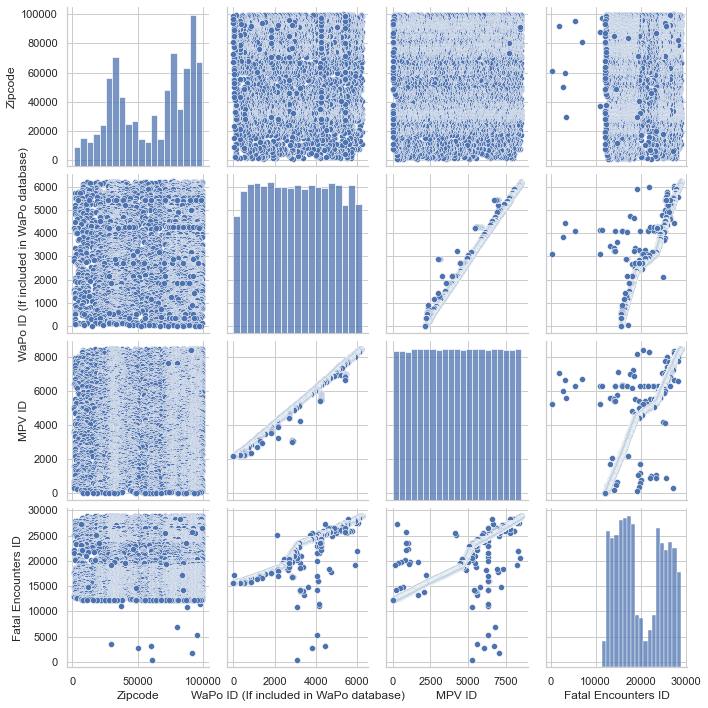

In [5]:
sns.pairplot(data=data_mapping)


In [6]:
# do we have any null values?

data_mapping.isnull().values.any()

# where are they?

for col in data_mapping.columns:
    null_count = data_mapping[col].isnull().sum()
    print(col, ": ", null_count)

Victim's name :  0
Victim's age :  15
Victim's gender :  13
Victim's race :  4
URL of image of victim :  3939
Date of Incident (month/day/year) :  0
Street Address of Incident :  95
City :  6
State :  0
Zipcode :  42
County :  14
Agency responsible for death :  16
ORI Agency Identifier (if available) :  2
Cause of death :  0
A brief description of the circumstances surrounding the death :  17
Official disposition of death (justified or other) :  11
Criminal Charges? :  0
Link to news article or photo of official document :  11
Symptoms of mental illness? :  11
Unarmed/Did Not Have an Actual Weapon :  0
Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database) :  2
Alleged Threat Level (Source: WaPo) :  2451
Fleeing (Source: WaPo) :  2893
Body Camera (Source: WaPo) :  2996
WaPo ID (If included in WaPo database) :  2915
Off-Duty Killing? :  8268
Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full

In [7]:
# drop some of the columns which have too many N/A or don't really help us

# not used and lots of missing
df1 = data_mapping.drop('URL of image of victim', axis=1)

# almost all NaN
df1 = df1.drop('Off-Duty Killing?', axis=1)

# not really used
df1 = df1.drop(['Street Address of Incident',
                'A brief description of the circumstances surrounding the death',
                "Victim's name",
                'Link to news article or photo of official document',
                'ORI Agency Identifier (if available)'],
                axis=1)

# rename a few annoying columns
df1.rename(columns={'Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx )':'geography'}, inplace=True)
df1.rename(columns={'Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)':'Alleged Weapon'}, inplace=True)

# fix a few of the duplicate groupings

df1['Symptoms of mental illness?'] = df1['Symptoms of mental illness?'].str.replace('unknown', 'Unknown')
df1['Symptoms of mental illness?'] = df1['Symptoms of mental illness?'].str.replace('Unkown', 'Unknown')

df1['Alleged Threat Level (Source: WaPo)'] = df1['Alleged Threat Level (Source: WaPo)'].str.replace('Other', 'other')

df1['Fleeing (Source: WaPo)'] = df1['Fleeing (Source: WaPo)'].str.replace('other', 'Other')
df1['Fleeing (Source: WaPo)'] = df1['Fleeing (Source: WaPo)'].str.replace('not fleeing', 'Not fleeing')
df1['Fleeing (Source: WaPo)'] = df1['Fleeing (Source: WaPo)'].str.replace('Not Fleeing', 'Not fleeing')
df1['Fleeing (Source: WaPo)'] = df1['Fleeing (Source: WaPo)'].str.replace('foot', 'Foot')
df1['Fleeing (Source: WaPo)'] = df1['Fleeing (Source: WaPo)'].str.replace('car', 'Car')

df1['Body Camera (Source: WaPo)'] = df1['Body Camera (Source: WaPo)'].str.replace('no', 'No')
df1['Body Camera (Source: WaPo)'] = df1['Body Camera (Source: WaPo)'].str.replace('Dashcam video', 'Dashcam Video')


Now see what needs further cleaning

In [8]:
for col in df1.columns:
    display(df1[col].value_counts())

25         279
31         275
27         268
Unknown    268
28         266
          ... 
40s          1
88           1
10           1
79           1
7            1
Name: Victim's age, Length: 88, dtype: int64

Male           8055
Female          425
Transgender       9
Unknown           4
Male              1
Name: Victim's gender, dtype: int64

White               3739
Black               2138
Hispanic            1467
Unknown race         863
Asian                131
Native American      119
Pacific Islander      46
Name: Victim's race, dtype: int64

6/16/2013     10
12/10/2019     9
5/3/2020       9
1/24/2017      9
12/26/2017     9
              ..
9/17/2020      1
6/7/2019       1
5/28/2018      1
2/6/2015       1
12/19/2016     1
Name: Date of Incident (month/day/year), Length: 2675, dtype: int64

Phoenix         121
Los Angeles     121
Houston         109
Chicago          84
San Antonio      66
               ... 
Strongsville      1
Sunnyside         1
Metropolis        1
Holly Pond        1
Interlachen       1
Name: City, Length: 3102, dtype: int64

CA    1312
TX     785
FL     613
AZ     376
GA     299
CO     267
WA     245
OK     236
NC     236
OH     229
MO     226
TN     201
IL     190
PA     185
NY     174
LA     167
NM     158
AL     153
NV     144
IN     141
MD     139
KY     137
VA     136
SC     133
MI     133
WI     125
OR     124
AR     117
MS     115
NJ     113
UT      94
MN      92
KS      80
WV      76
MA      58
ID      53
IA      52
MT      48
AK      47
CT      40
NE      39
HI      39
ME      34
DC      27
SD      26
WY      22
DE      21
NH      18
ND      14
VT      12
RI       6
Name: State, dtype: int64

88001.0    11
93307.0    10
90044.0    10
87121.0    10
85009.0    10
           ..
30428.0     1
78942.0     1
67132.0     1
85085.0     1
37888.0     1
Name: Zipcode, Length: 5329, dtype: int64

Los Angeles    361
Maricopa       231
Harris         136
Jefferson      124
Orange         123
              ... 
Churchill        1
Taney            1
Cooke            1
Montrose         1
Lycoming         1
Name: County, Length: 1152, dtype: int64

Los Angeles Police Department                                                                                                                                 132
Phoenix Police Department                                                                                                                                     116
Los Angeles County Sheriff's Department                                                                                                                       101
Chicago Police Department                                                                                                                                      81
New York Police Department                                                                                                                                     79
                                                                                                                                                             ... 
Deschutes County Sheriff's O

Gunshot                                    7833
Gunshot, Taser                              253
Taser                                       247
Vehicle                                      44
Beaten                                       31
Physical Restraint                           25
Tasered                                      18
Asphyxiated                                   9
Physical restraint                            9
Other                                         5
Gunshot, Police Dog                           5
Gunshot, Pepper Spray                         4
Pepper Spray                                  4
Bean bag                                      2
Taser, Physical Restraint                     2
Beaten/Bludgeoned with instrument             1
Baton, Pepper Spray, Physical Restraint       1
Gunshot, Taser, Baton                         1
Gunshot, Stabbed                              1
Gunshot, Taser, Beanbag Shotgun               1
Taser, Pepper Spray, Beaten             

Pending investigation/No Known Charges                                                     4862
Unreported                                                                                 1225
Justified                                                                                   651
Pending investigation                                                                       446
Justified by District Attorney                                                              350
                                                                                           ... 
Justified by Fifth Judicial Circuit Solicitor                                                 1
Charged, Convicted of second-degree murder, Sentenced to 20 years in prison                   1
Charged, Convicted of misdemeanor misconduct in office, Sentenced to 3 years probation        1
unknown                                                                                       1
Charged with involuntary manslaughter, A

No known charges                                                                 8361
Charged with a crime                                                               69
Charged, Acquitted                                                                 29
Charged, Mistrial                                                                   6
Charged, Charges Dropped                                                            5
Charged, Convicted                                                                  4
Charged, Convicted, Sentenced to 30 years in prison                                 2
Charged, Convicted, Sentenced to life in prison                                     2
Charged, Convicted, Sentenced to 5 years probation.                                 2
Charged, Convicted, Sentenced to 40 years in prison                                 1
Charged, Convicted, Sentenced to 4 years                                            1
Charged, Convicted, Sentenced to 1 year in jail, 3 yea

No                     5415
Yes                    1598
Unknown                1164
Drug or alcohol use     318
Unknown                   1
Name: Symptoms of mental illness?, dtype: int64

Allegedly Armed                          6084
Unarmed/Did Not Have an Actual Weapon    1164
Unclear                                   697
Vehicle                                   562
Name: Unarmed/Did Not Have an Actual Weapon, dtype: int64

gun                  4432
knife                1129
no object             888
undetermined          532
vehicle               499
                     ... 
knife and taser         1
wooden nightstand       1
ax and knife            1
stick                   1
railroad spike          1
Name: Alleged Weapon, Length: 170, dtype: int64

attack          3922
other           1803
undetermined     331
Name: Alleged Threat Level (Source: WaPo), dtype: int64

Not fleeing    3770
Car             937
Foot            732
Other           175
Name: Fleeing (Source: WaPo), dtype: int64

No                    4905
Yes                    592
Surveillance Video       5
Bystander Video          4
Dashcam Video            3
Surveillance video       2
Name: Body Camera (Source: WaPo), dtype: int64

3232.0    2
3784.0    2
6117.0    2
3516.0    2
4731.0    1
         ..
6020.0    1
4650.0    1
3766.0    1
3226.0    1
6144.0    1
Name: WaPo ID (If included in WaPo database), Length: 5588, dtype: int64

Suburban        4240
Urban           2287
Rural           1899
Undetermined      73
Name: geography, dtype: int64

5972.0    2
4603.0    1
4629.0    1
497.0     1
590.0     1
         ..
2906.0    1
2268.0    1
2129.0    1
1794.0    1
8448.0    1
Name: MPV ID, Length: 8484, dtype: int64

28926.0    2
24323.0    2
28921.0    2
28920.0    2
20232.0    1
          ..
25960.0    1
14498.0    1
17377.0    1
14854.0    1
28160.0    1
Name: Fatal Encounters ID, Length: 8413, dtype: int64

Taking a look at the victim's race

In [9]:
data_mapping["Victim's race"].value_counts()

White               3739
Black               2138
Hispanic            1467
Unknown race         863
Asian                131
Native American      119
Pacific Islander      46
Name: Victim's race, dtype: int64

Where are most of the events taking place?


In [10]:
display(df1["State"].value_counts())
display(df1["City"].value_counts())

CA    1312
TX     785
FL     613
AZ     376
GA     299
CO     267
WA     245
OK     236
NC     236
OH     229
MO     226
TN     201
IL     190
PA     185
NY     174
LA     167
NM     158
AL     153
NV     144
IN     141
MD     139
KY     137
VA     136
SC     133
MI     133
WI     125
OR     124
AR     117
MS     115
NJ     113
UT      94
MN      92
KS      80
WV      76
MA      58
ID      53
IA      52
MT      48
AK      47
CT      40
NE      39
HI      39
ME      34
DC      27
SD      26
WY      22
DE      21
NH      18
ND      14
VT      12
RI       6
Name: State, dtype: int64

Phoenix         121
Los Angeles     121
Houston         109
Chicago          84
San Antonio      66
               ... 
Strongsville      1
Sunnyside         1
Metropolis        1
Holly Pond        1
Interlachen       1
Name: City, Length: 3102, dtype: int64

In [11]:
# your code here 



df1['Cause of death'] = df1['Cause of death'].str.replace('Tasered', 'Taser')
df1['Cause of death'] = df1['Cause of death'].str.replace('Taser, Beaten', 'Taser')
df1['Cause of death'] = df1['Cause of death'].str.replace('Taser, Baton', 'Taser')
df1['Cause of death'] = df1['Cause of death'].str.replace('Taser, Physical Restraint', 'Taser')
df1['Cause of death'] = df1['Cause of death'].str.replace('Taser, Pepper Spray, Beaten', 'Taser')
df1['Cause of death'] = df1['Cause of death'].str.replace('Taser, Pepper spray, beaten', 'Taser')

df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Police Dog', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Taser', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Pepper Spray', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Pepper spray', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Pepper Spray', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Bean Bag Gun', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Beanbag Gun', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Beanbag Shotgun', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Stabbed', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Unspecified Less Lethal Weapon', 'Gunshot')
df1['Cause of death'] = df1['Cause of death'].str.replace('Gunshot, Vehicle', 'Gunshot')

df1['Cause of death'] = df1['Cause of death'].str.replace('Physical restraint', 'Physical Restraint')
df1['Cause of death'] = df1['Cause of death'].str.replace('Baton, Pepper Spray, Physical Restraint', 'Beaten')
df1['Cause of death'] = df1['Cause of death'].str.replace('Beaten/Bludgeoned with instrument', 'Beaten')
df1['Cause of death'] = df1['Cause of death'].str.replace('Chemical agent/Pepper spray ', 'Pepper Spray')



df1['Cause of death'].value_counts()


Gunshot                        8103
Taser                           271
Vehicle                          44
Physical Restraint               34
Beaten                           33
Asphyxiated                       9
Other                             5
Pepper Spray                      4
Bean bag                          2
Bomb                              1
Chemical agent/Pepper spray       1
Name: Cause of death, dtype: int64

In [12]:

df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 5 years probation.', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 30 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to life in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 1 year in prison and 4 years probation', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 40 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 16 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 5 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 6 years', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 1 year in jail, 3 years suspended', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted without parole, plus 16 years', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 14 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 7 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 12 years in prison and 8 years in probation', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 20 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 2.5 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 3 years probation', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 25 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 50 years', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 4 years', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted of reckless homicide, sentenced to 1 year in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 3 months in jail ', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 1 year in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 10 years in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 40 years to Life in prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted ', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to Life in Prison', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 3 months in jail', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Plead No Contest, Sentenced to 10 years probation', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convicted, Sentenced to 18 months', 'Charged, Convicted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Convictedin prison', 'Charged, Convicted')

df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Charges Dropped', 'Charged, Acquitted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged with a crime, Acquitted', 'Charged, Acquitted')
df1["Criminal Charges?"] = df1["Criminal Charges?"].str.replace('Charged, Mistrial, Plead Guilty to Civil Rights Charges', 'Charged, Mistrial')


display(df1["Criminal Charges?"].value_counts())

No known charges        8361
Charged with a crime      69
Charged, Convicted        35
Charged, Acquitted        35
Charged, Mistrial          7
Name: Criminal Charges?, dtype: int64

In [13]:
df1["Symptoms of mental illness?"] = df1["Symptoms of mental illness?"].str.replace('Unknown ', 'Unknown')
df1["Symptoms of mental illness?"] = df1["Symptoms of mental illness?"].str.replace('nan', 'Unknown')
display(df1["Symptoms of mental illness?"].value_counts())

No                     5415
Yes                    1598
Unknown                1165
Drug or alcohol use     318
Name: Symptoms of mental illness?, dtype: int64

In [14]:
display(df1["Unarmed/Did Not Have an Actual Weapon"].value_counts())

Allegedly Armed                          6084
Unarmed/Did Not Have an Actual Weapon    1164
Unclear                                   697
Vehicle                                   562
Name: Unarmed/Did Not Have an Actual Weapon, dtype: int64

In [15]:
display(df1["Fleeing (Source: WaPo)"].value_counts())

Not fleeing    3770
Car             937
Foot            732
Other           175
Name: Fleeing (Source: WaPo), dtype: int64

In [16]:
df1["Body Camera (Source: WaPo)"] = df1["Body Camera (Source: WaPo)"].str.replace('Surveillance video', 'Surveillance Video')
df1["Body Camera (Source: WaPo)"] = df1["Body Camera (Source: WaPo)"].str.replace('nan', 'Unknown')

display(df1["Body Camera (Source: WaPo)"].value_counts())

No                    4905
Yes                    592
Surveillance Video       7
Bystander Video          4
Dashcam Video            3
Name: Body Camera (Source: WaPo), dtype: int64

In [17]:

df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, aquitted', 'Charged, Aquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Sentenced to 18 months', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with criminally negligent homicide, Acquitted', 'Charged, Aquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by District Attorney/Civil suit/Pending', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by County Commonwealth's Attorney", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by District Attorney", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Charges Tossed under Stand Your Ground law', 'Charged, Aquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder and aggravated assault', 'Charged, Aquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, charges dismissed', 'Charged, Aquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of murder, Sentenced to 30 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Pending investigation/No Known Charges; Minnesota Bureau of Criminal Apprehension, Minnesota State Patrol, Anoka County Sheriff's Office, Fridley Police Department, Lino Lakes Police Department", 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Pending investigation', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of involuntary manslaugher, Sentenced to 1 year in jail, 3 years suspended', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder and involuntary manslaughter, Convicted, Sentenced to Life in Prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by County Prosecuting Attorney', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, convicted of manslaughter', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Sentenced to 5 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Sentenced to five years probation.', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, Convicted of manslaughter, Sentenced to 14 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with negligent homicide', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified/Civil Suit/Family awarded money', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified; New York State Police investigation; Schwalm's brother offered condolences to the deputy because of his brother's illness.", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of involuntary manslaughter, Sentenced to 5 years in Prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of reckless manslaughter, Sentenced to 6 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of felony murder, Sentenced to life without parole, plus 16 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Unjustified, Officer fired', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Plead no contest, Sentenced to 10 years probation', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Pending investigation/No Known Charges/No Known Charges/No Known Charges/No Known Charges/No Known Charges', 'No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, Convicted of aggravated assault, violating the oath of his office and making a false statement, Sentenced to 12 years in prison and 8 years probation ', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('unknown', 'Unknown')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('No Known Charges/No Known Charges', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Cleared by coroner's inquest/Civil suit/Family awarded money", 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of misdemeanor misconduct in office, Sentenced to 3 years probation', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted and malfeasance', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by external agency', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted of second-degree murder, Sentenced to 20 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Mistrial', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted ', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with first-degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 3rd degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with reckless homicide, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Acquitted', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Pending investigation/No Known Charges/No Known Charges', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, possession of a firearm during the commission of a crime and violation of oath', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by State's Attorney/Civil suit/Pending", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Grand jury/No bill or Cleared/Justified', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof manslaughter and attempted murder, Sentenced to 25 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof voluntary manslaughter, Sentenced to 6 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Unjustified by internal review', 'Unjustified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Charged, Mistrial declared, Pled Guilty for Violating Walter Scott's Civil Rights", 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Grand jury/No bill or Cleared', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof voluntary manslaughter, Sentenced to 3 months in jail', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with involuntary manslaughter, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 2nd degreee murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof misdemeanor reckless conduct with a firearm, Sentenced to 1 year in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 1st degree wanton endangerment', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Prosecutor', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with felony negligent homicide, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Department of Justice', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by State's Attorney", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('No Known Chargess', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof aggravated manslaughter and child endangerment, Sentenced to 30 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, Convicted of aggravated assault, violating the oath of his office and making a false statement, Sentenced to 12 years in prison and 8 years probation', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof manslaughter, Sentenced to 2.5 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by coroner's inquest", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Attorney General', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof Third Degree Murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter and reckless discharge of firearm', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof first-degree murder, Sentenced to life in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Fifth Judicial Circuit Solicitor', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, Ruled not guilty by reason of insanity', 'Charged, Acquittted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Acquittted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with homicide and felony firearm charges, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with criminal homicide, assault, and reckless endangerment', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof felony murder, Sentenced to life in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof reckless homicide, sentenced to 1 year in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Convicted of violating oath of office, Sentenced to 1 year in prison and 4 years probation', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with voluntary manslaughter', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with involuntary manslaughter, Plead Guilty to Involuntary Manslaughter, Sentenced to 7 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof 2nd degree manslaughter, Sentenced to 4 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Murder / Suicide', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 2nd degree murder or first degree manslaughter', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof second-degree manslaughter and one count of official misconduct, Sentenced to five years probation.', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by State Attorney's Office", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Sentenced to 50 years', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged and Civil suit/Family awarded money', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('No Known Charges; Snohomish County Multiagency Response Team', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('No Known Charges ', 'No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with second-degree murder, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged witth 1st degree manslaughter, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Charges Dismissed in Federal Court', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 1st degree murder, armed criminal action and two counts of child endangerment, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by U.S. Attorney', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder and attemped murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Unjustified', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convicted, Sentenced to 10 years in prison', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by County Prosecutor's Office", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with involuntary manslaughter', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 1st degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Pending investigaton', 'No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by County State's Attorney", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Cleared by district attorney', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Special Prosecutor', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Administrative discipline/Civil suit/Family awarded money', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Charges Dropped', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by Solicitor's Office", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedof second-degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified/Civil suit/Family awarded money', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Ruled accidental', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('No Known Charges; Georgia Bureau of Investigation', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with homicide', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by outside agency/Civil suit/Family awarded money', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Other justified (Civilian board/Prosecutor/District Attorney/Coroner)', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Accidental', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with a crime', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Solicitor', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with 2nd degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Civil suit/Pending', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Cleared', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with second-degree murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Other justified (Civilian board/Prosecutor/District Attorney/Coroner) ', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Mistrial declared', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Aquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Administrative discipline', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified's Office", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Prosecuting Attorney', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Justified by Commonwealth's Attorney", 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Found Excusable', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter, Acquitted', 'Charged, Acquitted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace("Other justified (Civilian board/Prosecutor/District Attorney/Coroner)", 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by County Attorney', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by State Attorney', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by outside agency', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by County Prosecutor', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Other justified (Civilian board/Coroner/Medical examiner) ', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Murder/suicide', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged with manslaughter', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Civil suit/Family awarded money', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by internal review', 'Justified')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Under investigation', 'Pending investigation/No Known Charges')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Charged, Convictedwith felony murder', 'Charged, Convicted')
df1['Official disposition of death (justified or other)'] = df1['Official disposition of death (justified or other)'].str.replace('Justified by Inspector General', 'Justified')




display(df1['Official disposition of death (justified or other)'].value_counts())

Pending investigation/Pending investigation/No Known Charges                          4865
Justified                                                                             1451
Unreported                                                                            1225
Pending investigation/No Known Charges                                                 460
Unknown                                                                                254
Charged, Convicted                                                                     151
Charged, Acquitted                                                                      56
Other justified (Civilian board/Coroner/Medical examiner)                               14
Charged                                                                                  9
Pending investigation/Pending investigation/Pending investigation/No Known Charges       4
Other justified (Civilian board/Prosecutor/District Attorney/Coroner)                    3

Let's convert all the boolean predictors

In [18]:
# group all of the charges together for now
df1["Criminal Charges?_bool"]= df1["Criminal Charges?"].apply(lambda x: 0 if x=='No known charges' else 1)

# grouping all symptoms not classified as "yes"
df1["Symptoms of mental illness?_bool"]= df1["Symptoms of mental illness?"].apply(lambda x: 1 if x=='Yes' else 0)

# grouping all 'allegedly armed' as "yes" vs all other answers
df1["Unarmed/Did Not Have an Actual Weapon_bool"]= df1["Unarmed/Did Not Have an Actual Weapon"].apply(lambda x: 1 if x=='Allegedly Armed' else 0)

# grouping all spellings of 'not fleeing'
df1["Fleeing (Source: WaPo)_bool"]= df1["Fleeing (Source: WaPo)"].apply(lambda x: 0 if x in ['Not fleeing', 'not fleeing', 'Not Fleeing'] else 1)

# grouping all spellings of 'no'
df1["Body Camera (Source: WaPo)_bool"]= df1["Body Camera (Source: WaPo)"].apply(lambda x: 0 if x in ['No', 'no'] else 1)


In [19]:
display(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8507 entries, 0 to 8506
Data columns (total 27 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Victim's age                                        8492 non-null   object 
 1   Victim's gender                                     8494 non-null   object 
 2   Victim's race                                       8503 non-null   object 
 3   Date of Incident (month/day/year)                   8507 non-null   object 
 4   City                                                8501 non-null   object 
 5   State                                               8507 non-null   object 
 6   Zipcode                                             8465 non-null   float64
 7   County                                              8493 non-null   object 
 8   Agency responsible for death                        8491 non-null   object 
 9

None

Some of these datatypes still need to be recast

In [20]:
# Data type conversions

# age still has some odd values
# display(data_mapping["Victim's age"].head())
df1["Victim's age"] = data_mapping["Victim's age"].fillna(0)
#print(df1["Victim's age"].str.isdigit().sum())
df1["Victim's age"]= df1["Victim's age"].apply(lambda x: x if str(x).isdigit() else 0).astype("int")


# drop a few more NaN
#df1 = df1.fillna(str(0))
df1.dropna()

# recast some of the string categories as type string
df1["Victim's gender"] = df1["Victim's gender"].astype('str')
df1["Victim's race"] = df1["Victim's race"].astype('str')
df1["City"] = df1["City"].astype('str')
df1["State"] = df1["State"].astype('str')
df1["County"] = df1["County"].astype('str')
df1["Agency responsible for death"] = df1["Agency responsible for death"].astype('str')
df1["Cause of death"] = df1["Cause of death"].astype('str')
df1["Official disposition of death (justified or other)"] = df1["Official disposition of death (justified or other)"].astype('str')
df1["Symptoms of mental illness?"] = df1["Symptoms of mental illness?"].astype('str')
df1["Unarmed/Did Not Have an Actual Weapon"] = df1["Unarmed/Did Not Have an Actual Weapon"].astype('str')
df1["Alleged Weapon"] = df1["Alleged Weapon"].astype('str')
df1["Fleeing (Source: WaPo)"] = df1["Fleeing (Source: WaPo)"].astype('str')
df1["Body Camera (Source: WaPo)"] = df1["Body Camera (Source: WaPo)"].astype('str')
df1["Alleged Threat Level (Source: WaPo)"] = df1["Alleged Threat Level (Source: WaPo)"].astype('str')
df1["geography"] = df1["geography"].astype('str')

# Add year
df1['year'] = pd.DatetimeIndex(df1['Date of Incident (month/day/year)']).year


In [21]:
df1["Victim's gender"] = df1["Victim's gender"].str.replace('nan', 'Unknown')

display(df1["Victim's gender"].value_counts())

Male           8055
Female          425
Unknown          17
Transgender       9
Male              1
Name: Victim's gender, dtype: int64

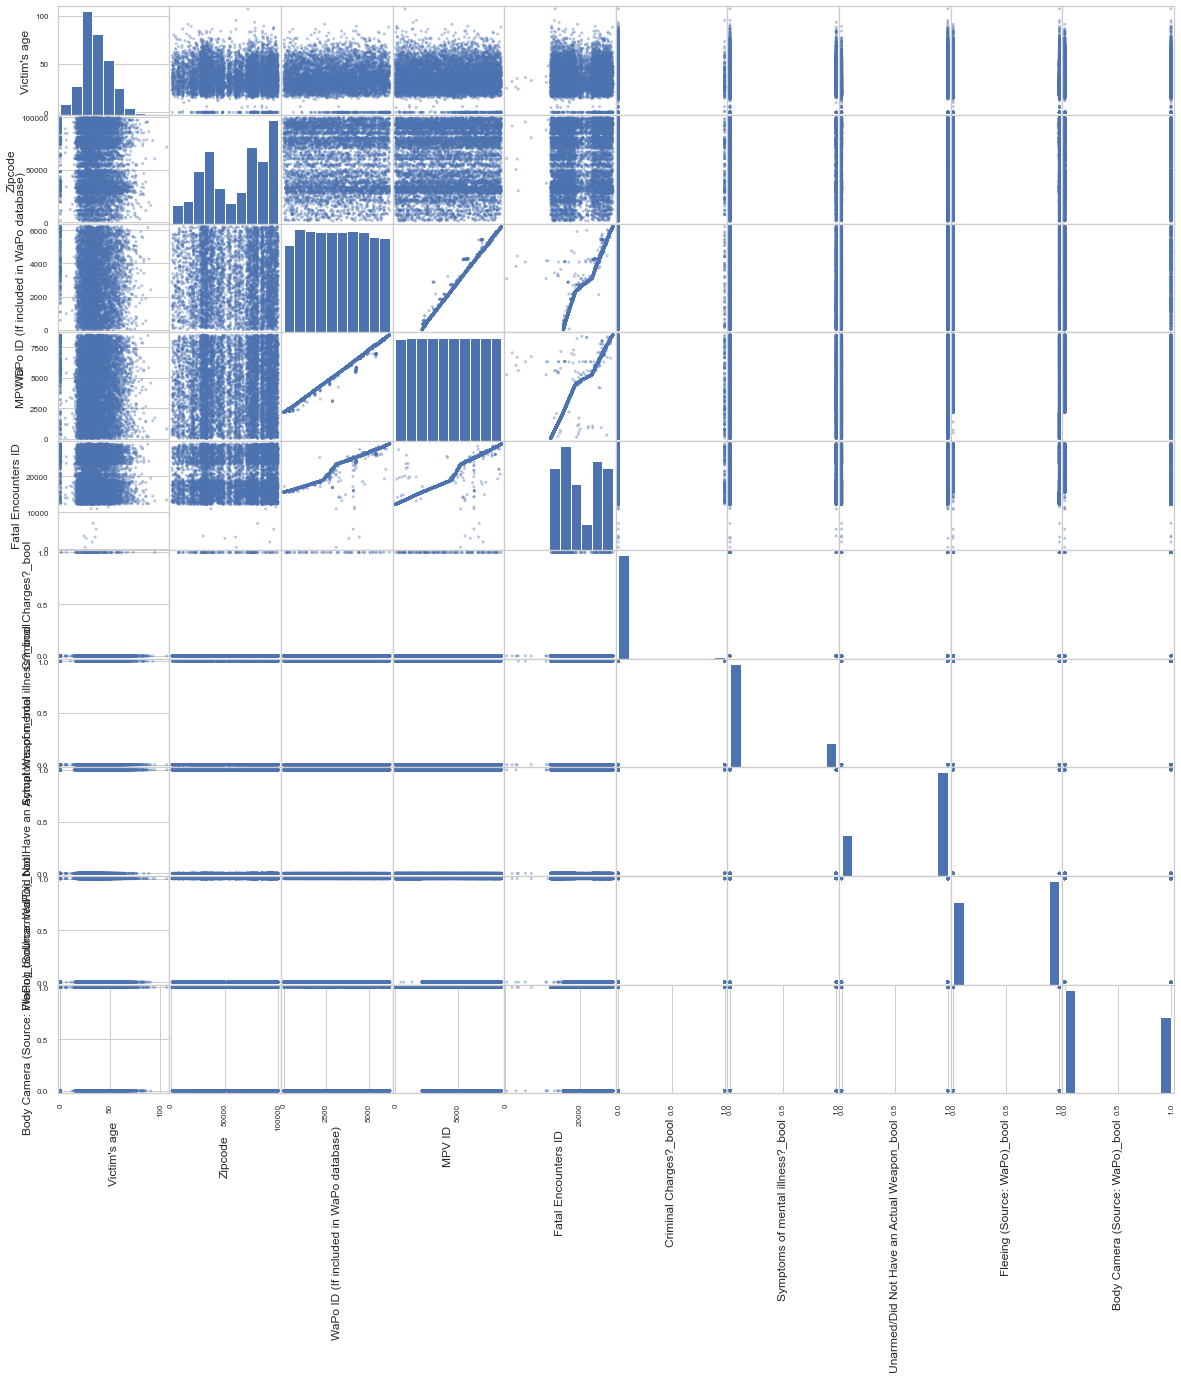

In [22]:
# check float features
grid_features = ["Victim's age", 'Zipcode', 'WaPo ID (If included in WaPo database)', 'MPV ID', 
                 'Fatal Encounters ID','Criminal Charges?_bool', 'Symptoms of mental illness?_bool',  
                 'Unarmed/Did Not Have an Actual Weapon_bool', 'Fleeing (Source: WaPo)_bool',
                 'Body Camera (Source: WaPo)_bool' ]

scatter = pd.plotting.scatter_matrix(df1[grid_features], alpha=0.4, figsize=(20,20));
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), rotation = 90)

### <div class='exercise'><b>Section 2: Now look at Washington Post Data</b></div>
[▲ Return to contents](#Contents)

<div class='exercise'>

    



</div>

In [23]:
display(data_wapo.head())
display(data_wapo.describe())

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


,id,age,longitude,latitude
count,5716.000000,5456.000000,5437.000000,5437.000000
mean,3173.216235,37.139113,-97.256366,36.650508
std,1789.492388,13.068117,16.629368,5.367021
min,3.000000,6.000000,-158.137000,19.498000
25%,1624.750000,27.000000,-112.134000,33.477000
50%,3174.500000,35.000000,-94.432000,36.100000
75%,4734.250000,46.000000,-83.066000,39.958000
max,6247.000000,91.000000,-68.014000,71.301000


In [24]:
display(data_wapo.columns)

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact'], dtype='object')

In [25]:
print('Dataset shape: ', data_wapo.shape)

data_wapo.info()

Dataset shape:  (5716, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5716 entries, 0 to 5715
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5716 non-null   int64  
 1   name                     5499 non-null   object 
 2   date                     5716 non-null   object 
 3   manner_of_death          5716 non-null   object 
 4   armed                    5503 non-null   object 
 5   age                      5456 non-null   float64
 6   gender                   5715 non-null   object 
 7   race                     5109 non-null   object 
 8   city                     5716 non-null   object 
 9   state                    5716 non-null   object 
 10  signs_of_mental_illness  5716 non-null   bool   
 11  threat_level             5716 non-null   object 
 12  flee                     5426 non-null   object 
 13  body_camera              5716 non-null   bool   
 1

In [26]:
# do we have any null values?

data_wapo.isnull().values.any()

# where are they?

for col in data_wapo.columns:
    null_count = data_wapo[col].isnull().sum()
    print(col, ": ", null_count)

id :  0
name :  217
date :  0
manner_of_death :  0
armed :  213
age :  260
gender :  1
race :  607
city :  0
state :  0
signs_of_mental_illness :  0
threat_level :  0
flee :  290
body_camera :  0
longitude :  279
latitude :  279
is_geocoding_exact :  0


In [27]:
# drop some of the columns which have too many N/A or don't really help us

# not really used
df2 = data_wapo.drop('name', axis=1)


In [28]:
# Convert dae to datetime pandas value 
# https://stackoverflow.com/a/33368021/8970591
# errors=coerce -> 'if the conversion fails for any particular string then those rows are set to NaT'
# errors=raise -> then invalid parsing will raise an exception.
df2['date'] = pd.to_datetime(df2['date'], errors='raise')

Index(['id', 'date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact'], dtype='object')

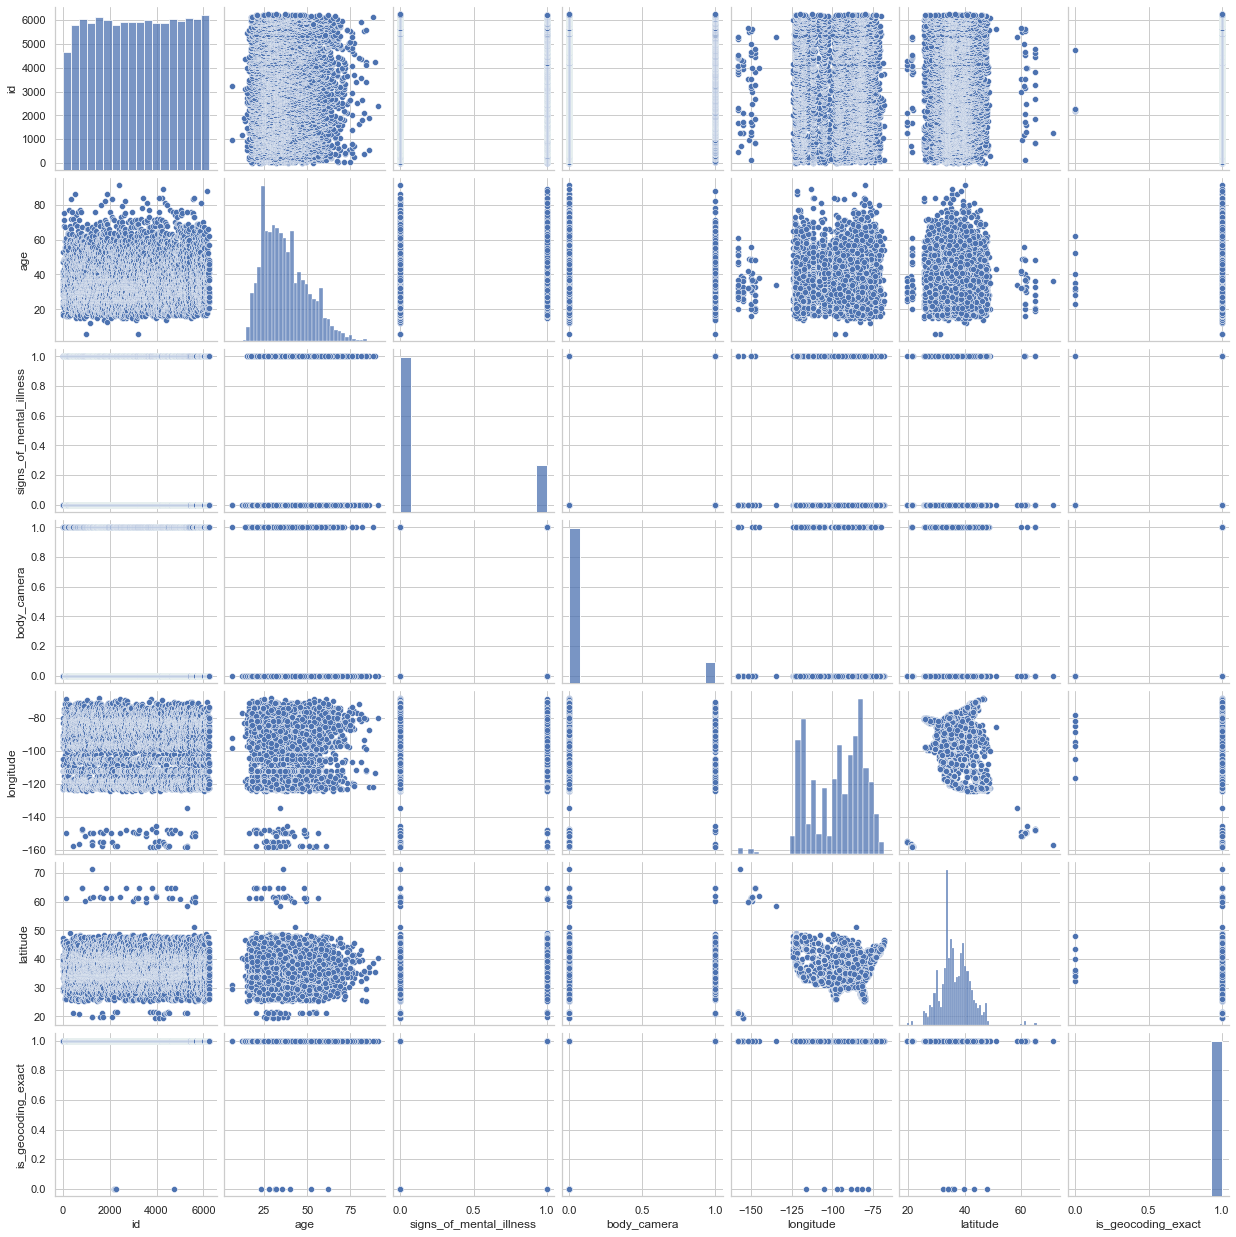

In [29]:
display(df2.columns)
sns.pairplot(data=df2)


#### Inspect data
Check value count info for all columns

In [30]:
for col in df2.columns:
    display(df2[col].value_counts())

2047    1
689     1
661     1
4759    1
2712    1
       ..
3431    1
5480    1
1386    1
3435    1
2049    1
Name: id, Length: 5716, dtype: int64

2018-04-01    9
2019-01-28    9
2020-05-26    9
2018-02-01    9
2018-01-06    9
             ..
2016-10-22    1
2018-02-24    1
2016-05-20    1
2016-04-29    1
2016-04-25    1
Name: date, Length: 1962, dtype: int64

shot                5427
shot and Tasered     289
Name: manner_of_death, dtype: int64

gun                                 3252
knife                                846
unarmed                              359
toy weapon                           193
undetermined                         177
                                    ... 
baseball bat and bottle                1
baseball bat and fireplace poker       1
gun and machete                        1
metal rake                             1
vehicle and machete                    1
Name: armed, Length: 95, dtype: int64

31.0    195
25.0    189
27.0    183
32.0    177
33.0    177
       ... 
79.0      1
89.0      1
91.0      1
12.0      1
78.0      1
Name: age, Length: 78, dtype: int64

M    5463
F     252
Name: gender, dtype: int64

W    2595
B    1345
H     947
A      94
N      81
O      47
Name: race, dtype: int64

Los Angeles    89
Phoenix        80
Houston        61
Las Vegas      50
San Antonio    47
               ..
Maspeth         1
Bellville       1
Oxon Hill       1
Porteau         1
Everton         1
Name: city, Length: 2565, dtype: int64

CA    853
TX    506
FL    379
AZ    262
CO    209
GA    197
OK    171
NC    168
WA    163
OH    159
TN    149
MO    146
LA    116
PA    113
NM    112
IL    109
AL    105
NY    105
NV    104
KY    103
IN    101
VA     97
WI     96
SC     93
OR     87
MI     86
AR     84
MD     81
NJ     71
UT     70
MS     67
MN     64
WV     56
KS     52
ID     43
AK     40
IA     36
MA     35
MT     34
HI     30
NE     25
ME     22
CT     21
SD     17
DC     14
WY     14
DE     13
NH     13
ND     12
VT      9
RI      4
Name: state, dtype: int64

False    4390
True     1326
Name: signs_of_mental_illness, dtype: int64

attack          3697
other           1763
undetermined     256
Name: threat_level, dtype: int64

Not fleeing    3567
Car             937
Foot            736
Other           186
Name: flee, dtype: int64

False    5029
True      687
Name: body_camera, dtype: int64

-112.134    7
-112.152    6
-111.978    5
-97.132     4
-118.457    4
           ..
-84.268     1
-71.518     1
-94.138     1
-80.537     1
-112.078    1
Name: longitude, Length: 4846, dtype: int64

33.495    8
33.415    7
33.480    7
33.568    5
34.033    5
         ..
43.131    1
31.375    1
31.125    1
34.500    1
28.500    1
Name: latitude, Length: 4401, dtype: int64

True     5708
False       8
Name: is_geocoding_exact, dtype: int64

In [31]:

display(df2['manner_of_death'].value_counts())

shot                5427
shot and Tasered     289
Name: manner_of_death, dtype: int64

In [32]:
pd.set_option('display.max_rows', 20)

display(df2['armed'].value_counts())
print(df2['armed'].unique())

gun                                 3252
knife                                846
unarmed                              359
toy weapon                           193
undetermined                         177
                                    ... 
baseball bat and bottle                1
baseball bat and fireplace poker       1
gun and machete                        1
metal rake                             1
vehicle and machete                    1
Name: armed, Length: 95, dtype: int64

['gun' 'unarmed' 'toy weapon' 'nail gun' 'knife' nan 'shovel' 'vehicle'
 'hammer' 'hatchet' 'sword' 'machete' 'box cutter' 'undetermined'
 'metal object' 'screwdriver' 'lawn mower blade' 'flagpole'
 'guns and explosives' 'cordless drill' 'crossbow' 'metal pole' 'Taser'
 'metal pipe' 'metal hand tool' 'blunt object' 'metal stick'
 'sharp object' 'meat cleaver' 'carjack' 'chain' "contractor's level"
 'unknown weapon' 'stapler' 'beer bottle' 'bean-bag gun'
 'baseball bat and fireplace poker' 'straight edge razor' 'gun and knife'
 'ax' 'brick' 'baseball bat' 'hand torch' 'chain saw' 'garden tool'
 'scissors' 'pole' 'pick-axe' 'flashlight' 'baton' 'spear' 'chair'
 'pitchfork' 'hatchet and gun' 'rock' 'piece of wood' 'bayonet' 'pipe'
 'glass shard' 'motorcycle' 'pepper spray' 'metal rake' 'crowbar' 'oar'
 'machete and gun' 'tire iron' 'air conditioner' 'pole and knife'
 'baseball bat and bottle' 'fireworks' 'pen' 'chainsaw' 'gun and sword'
 'gun and car' 'pellet gun' 'claimed to be armed' 'B

In [33]:
display(df2['gender'].value_counts())

M    5463
F     252
Name: gender, dtype: int64

In [34]:
display(df2['threat_level'].value_counts())

attack          3697
other           1763
undetermined     256
Name: threat_level, dtype: int64

#### Additional population data
We also believe that population density and classifications that could be made from this information like rural or urban cities could be important in our models. So we scraped the List of United States cities by population wikipedia page to retrieve the densities of the most densely populated cities. This wikipedia page sourced their information from the United States Census Bureau. We matched the city names from our the listed incidents of the Washington Post dataset to the population density from the scraped data and added a new Population density km2 column to our dataset.

### Reading our scraped city population data

We scraped a wikipedia entry with population densities from cities with our 100k residents. We use this to determine if our incidents happened in urban or dense areas

In [35]:
# Use the offline reverse_geopy lubrary to match cities to the coordinates
# http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/
def addCityBasedOnCoordinates(row):
    # Get coordinate values
    lat, long = row['latitude'] , row['longitude']
    
    # Null check
    if str(lat) == 'nan' or str(long) == 'nan':
        # Return original city
        return row['city']
    location_info = reverse_geocode.get((lat, long))
    return location_info['city']
    

# Save the result in a new column
df2['city_lat_long'] = df2.apply(addCityBasedOnCoordinates, axis=1)

# Inspect the results
display(df2.head())

,id,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_lat_long
0,3,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton
1,4,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha
2,5,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita
3,8,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District
4,9,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans


### Population density by city name
We got the population density estimates from [SimpleMaps](https://simplemaps.com/data/us-cities). They've built this dataset from the ground up using authoritative sources such as the U.S. Geological Survey and U.S. Census Bureau.
We are going to use this data to add a city population density column to each incident.

In [36]:
# Data from https://simplemaps.com/data/us-cities
city_df = pd.read_csv(f'{data_dir}/uscities-simplemaps.csv')
city_df.head()


,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715.0,polygon,False,True,America/New_York,1,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276.0,polygon,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90037 90031 9000...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6862,8604203,4574.0,polygon,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7839,-80.2102,6445545,5019.0,polygon,False,True,America/New_York,1,33129 33125 33126 33127 33128 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7936,-96.7662,5743938,1526.0,polygon,False,True,America/Chicago,1,75287 75098 75233 75254 75251 75252 75253 7503...,1840019440


### Adding the incident's city population density 
Now that we have the original city (and sometime county) and backup city names from the coordinates, we can make the cross reference on the city population density dataset. 

In [37]:
# The average city density from each us city, needed for imputation
avg_city_dens = city_df['density'].mean()

# To store the fails for inspection
df_fails = pd.DataFrame(columns=df2.columns)

# Use the offline reverse_geopy lubrary to match cities to the coordinates
# http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/
def addCityDensity(row):
    global df_fails
    
    # Grab values to match
    state = row['state']
    city = row['city']
    
    # Match based on STATE and city, because a lot of states have cities with the same name
    df_matches = city_df.loc[(city_df['state_id'] == state ) & (city_df['state_id'] == state ) & (city_df['city'] == city) ]
    
    # Try backup cities that were matched by coordinates
    if len(df_matches.index) == 0:
        city_xtra = row['city_lat_long']
        df_matches = city_df.loc[(city_df['state_id'] == state ) & (city_df['city'] == city_xtra) ]

    # Null check if no matched at all...
    if len(df_matches.index) == 0:
        # print(f"Could not match city: '{city}' or '{city_xtra}' so imputing average....")
        df_fails = df_fails.append(row, ignore_index=True)
        return avg_city_dens
    
    # Only happened once for a place in Florida and since the wsp doesn't have county, we impute the avg
    elif len(df_matches.index) > 1:
        # display(df_matches)
        mean_similar_matches = df_matches['density'].mean()
        match_cnt = len(df_matches.index)
        print(f"Multiple matches ({match_cnt}) for -> '{(city)} - {state}' so imputing their average: {round(mean_similar_matches, 2)}")
        return mean_similar_matches

    # Return first match
    return df_matches['density'].iloc[0]


# Save the result in a new column
df2['city_density'] = df2.apply(addCityDensity, axis=1)
amount_total =  len(df2.index)
amount_fail = len(df_fails.index)

# Output basic stats
print(f"\n{amount_fail} from the total of {amount_total} did not match any city name from the original cities and coordinates based cities")
print(f"So we have imputed the overal city density for them of: {round(avg_city_dens, 2)}\n")

# Inspect the new df and the rows which did not match
display(df2.head())
display(df_fails.head())

Multiple matches (3) for -> 'Midway - FL' so imputing their average: 507.67

217 from the total of 5716 did not match any city name from the original cities and coordinates based cities
So we have imputed the overal city density for them of: 515.61



,id,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_lat_long,city_density
0,3,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton,708.0
1,4,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha,2915.0
2,5,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita,931.0
3,8,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District,7256.0
4,9,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans,804.0


,id,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_lat_long
0,98,2015-01-21,shot,gun,54.0,M,W,Derry,NH,True,attack,Not fleeing,False,-71.337,42.908,True,Methuen
1,136,2015-02-09,shot,gun,61.0,M,W,Smyrna,ME,True,undetermined,Not fleeing,False,-68.104,46.159,True,Florenceville-Bristol
2,139,2015-02-10,shot,gun,49.0,M,B,Whitehaven,TN,False,attack,Not fleeing,False,-90.054,35.025,True,Southaven
3,309,2015-03-21,shot,gun,44.0,M,W,Clarendon,NY,False,attack,Car,False,-78.047,43.190,True,Gates-North Gates
4,234,2015-03-22,shot and Tasered,undetermined,21.0,M,B,Islip,NY,False,attack,Car,False,-73.238,40.740,True,Setauket-East Setauket


### Adding the 'urban' classifier

We used a simple metric of a population km2 density above 2900 to be an 'urban' city. I got the idea from:
https://medium.com/codait/got-zip-code-data-prep-it-for-analytics-7022b47652d9

But we can probably make the classification more accurate or perhaps add more classes or create our own density based classes which could perhaps by good predictors for our model

In [38]:
# Add population density
# Classification from: https://medium.com/codait/got-zip-code-data-prep-it-for-analytics-7022b47652d9

# Mappping
# 2 = Urban (dens >2900)
# 1 = Suburban (100< dense < 2900)
# 0 = Rural (dens < 100)

def func(x):
    if x > 2900:
        return 'urban'
    elif 100 < x <= 2900:
        return 'suburban'
    elif x <= 100:
        return 'rural'

df2['urban'] = df2['city_density'].apply(func)

df2.head()

,id,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_lat_long,city_density,urban
0,3,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton,708.0,suburban
1,4,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha,2915.0,urban
2,5,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita,931.0,suburban
3,8,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District,7256.0,urban
4,9,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans,804.0,suburban


### Adding the 'party' classifier

This project statement originated with a discussion about Black Lives Matter and other political movements. While this analysis is focuesed more on race and time distributions, the "party" classifier uses the political affiliation in different areas of the country to attempt to identify whether political viewpoints are reflected in the likelihood of police violence and the response to those events.

Used voting records over the timeframe of the data to classify by state. (Need to boil this down to County if possible)

Reference: https://www.nytimes.com/2016/08/23/upshot/50-years-of-electoral-college-maps-how-the-us-turned-red-and-blue.html


In [39]:
# Add year
df2['year'] = pd.DatetimeIndex(df2['date']).year

# which states are blue?
blue_states = {2012: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2013: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2014: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2015: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2016: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2017: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2018: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2019: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2020: ['AZ', 'CA', 'CO', 'CT', 'DE', 'DC', 'GA', 'HI', 'IL', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'] 
              }

# process
def f1(x):
    return 1 if x.State in blue_states[x.year] else 0
def f2(x):
    return 1 if x.state in blue_states[x.year] else 0

df2['party'] = df2.apply(f2, axis=1)
df1['party'] = df1.apply(f1, axis=1)

# process further
#party_df[['shootings_black', 'shootings_white', 'shootings_other', 'rate_black', 'rate_white', 'rate_other' ]] = party_df[['shootings_black', 'shootings_white', 'shootings_other', 'rate_black', 'rate_white', 'rate_other']].fillna(0)
    

display(df2.head())



,id,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_lat_long,city_density,urban,year,party
0,3,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton,708.0,suburban,2015,1
1,4,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha,2915.0,urban,2015,1
2,5,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita,931.0,suburban,2015,0
3,8,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District,7256.0,urban,2015,1
4,9,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans,804.0,suburban,2015,1


Need to recast some of the object types as correct values

In [40]:
# Data type conversions
# df2['name'] = df2['name'].astype('category')
df2['manner_of_death'] = df2['manner_of_death'].astype('category')
df2['armed'] = df2['armed'].astype('str')
df2['gender'] = df2['gender'].astype('str')
df2['race'] = df2['race'].astype('str')
df2['city'] = df2['state'].astype('str')
df2['threat_level'] = df2['threat_level'].astype('str')
df2['flee'] = df2['flee'].astype('str')
df2['signs_of_mental_illness'] = df2['signs_of_mental_illness'].astype('int')
df2['body_camera'] = df2['body_camera'].astype('str')
df2['is_geocoding_exact'] = df2['is_geocoding_exact'].astype('str')

# check again
df2.dtypes

id                          int64
date               datetime64[ns]
manner_of_death          category
armed                      object
age                       float64
                        ...      
city_lat_long              object
city_density              float64
urban                      object
year                        int64
party                       int64
Length: 21, dtype: object

### <div class='exercise'><b>Section 3: Make some Plots!</b></div>
[▲ Return to contents](#Contents)

<div class='exercise'>

</div>

In [41]:
def plot_value_counts_barchart(df_plot, class_key, verbose=False, normalize=False,
                               is_custom=False, custom_values=None):
    # Grab the value counts, and use custom ones if needed
    # e.g. date or categroical group
    if is_custom:
        df_values = custom_values
    else:
        df_values = df_plot[class_key].value_counts(normalize=normalize)
    
    if verbose:
        display(df_values)
    
    # Create the plot ax object
    ax = df_values.plot(kind='bar', figsize=(14,8))
    
    # Set and rotate the labels for better readability 
#     ax.set_xticklabels(preds, rotation=45, direction="in", rotation_mode="anchor")
    ax.tick_params(axis='x', rotation=45, direction="in",)
    
    # Set the labels
    ax.set_xlabel(class_key.capitalize(), fontsize=15)
    ax.set_ylabel("Frequency", fontsize=15)
    
    # Create the title extenstion and then set title
    title_ext_norm = " - Normalized" if normalize == True else ""
    ax.set_title(f"Incident frequency by {class_key.capitalize()}{title_ext_norm}", fontsize=18)
    
    plt.show()

### State by state 
We see that CA, TX and FL by far have the most police indcident. If you look at the normalized (so by ratio), chart you see an even bigger.

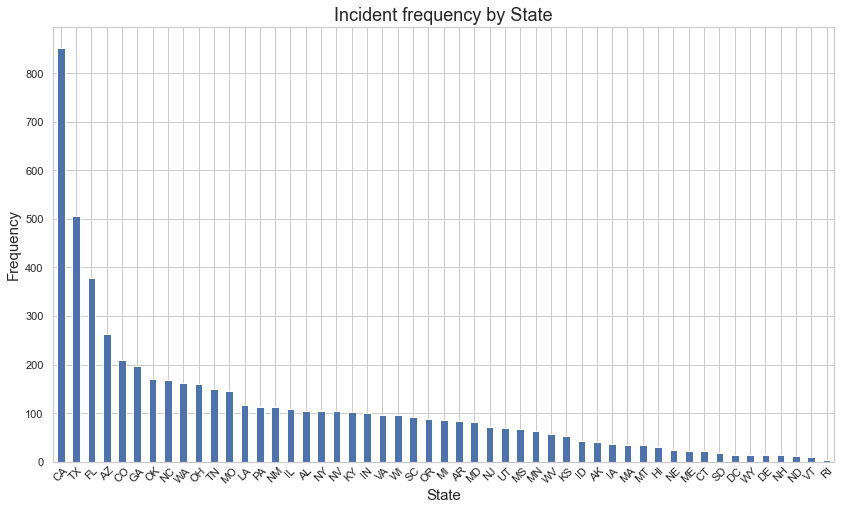

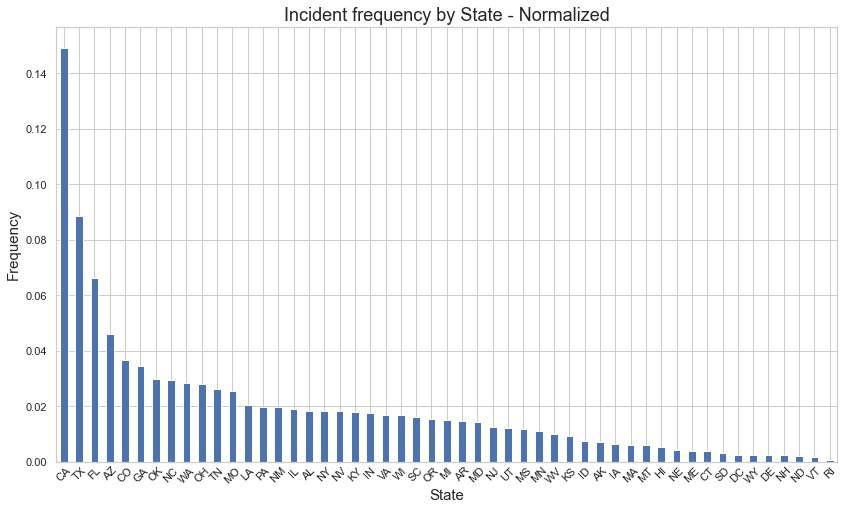

In [42]:
# WSP: Get incident state counts
per_state_df = df2.groupby(["state"])

# Plot state by state count 
plot_value_counts_barchart(df2, 'state', verbose=False, normalize=False)

# Plot state by state count 
plot_value_counts_barchart(df2, 'state', verbose=False, normalize=True)

In [43]:
# Get the population of each state from the 2019 Cencus data
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
population_summary = population_df[population_df['STATE']!=0][['NAME','POPESTIMATE2019']]
population_summary['abbrev'] = population_summary['NAME'].map(us_state_abbrev)
population_summary.set_index('abbrev',inplace=True)

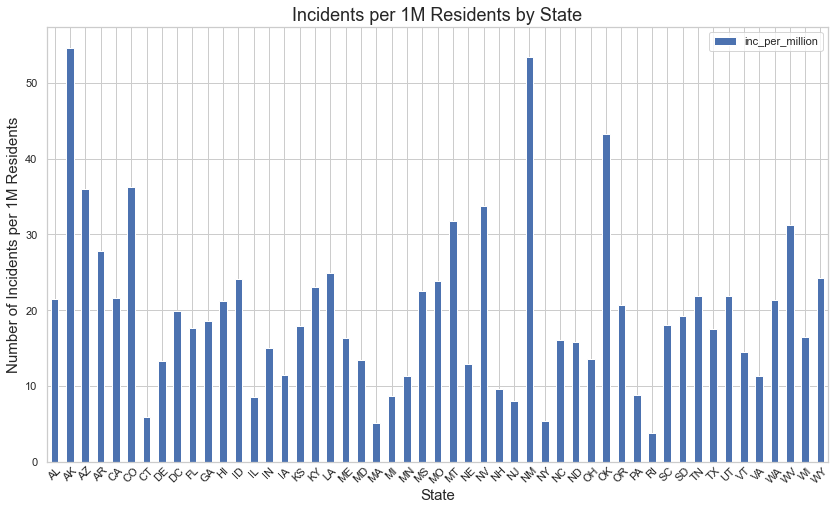

In [44]:
state_df= pd.concat([population_summary,df2['state'].groupby([df2.state]).agg('count')],axis=1).drop(index='PR')
state_df['inc_per_million'] = state_df['state']/state_df['POPESTIMATE2019']*1000000
ax = state_df.drop(columns=['NAME','POPESTIMATE2019','state']).plot(kind='bar', figsize=(14,8))
ax.tick_params(axis='x', rotation=45, direction="in",)
ax.set_xlabel("State", fontsize=15)
ax.set_ylabel("Number of Incidents per 1M Residents", fontsize=15)
ax.set_title("Incidents per 1M Residents by State", fontsize=18)
plt.show()

### Year by year for all incidents
There doesn't seem to be a very clear indication that the indicents grew on year to year basis 

This data was sourced at the 10th month of 2020, so 2020 could at the end of this year also be similar to the previous years

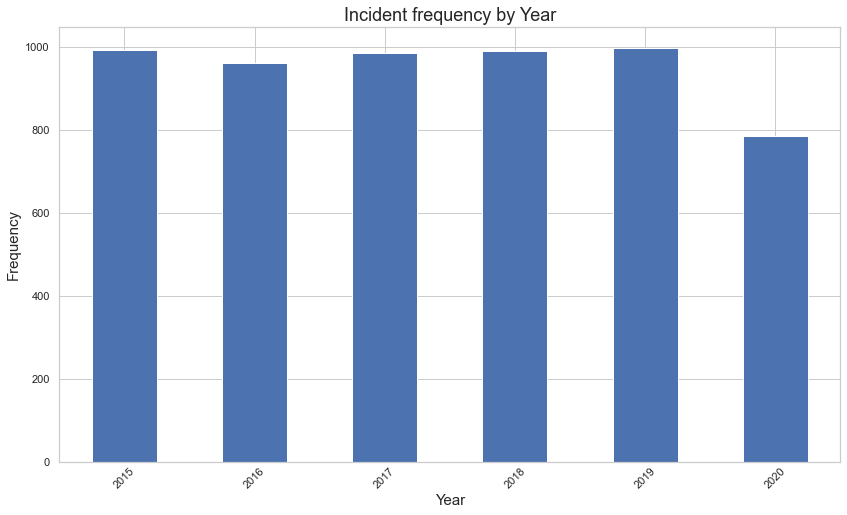

In [45]:
# Plot state by year 
df_by_year = df2['date'].groupby([df2.date.dt.year]).agg('count')
plot_value_counts_barchart(df2, 'year', is_custom=True, custom_values=df_by_year)

### Incidents by race

This is the [original classification](https://github.com/washingtonpost/data-police-shootings):
race:

`race`:
- `W`: White, non-Hispanic
- `B`: Black, non-Hispanic
- `A`: Asian
- `N`: Native American
- `H`: Hispanic
- `O`: Other
- `None`: unknown

We want add weights the incident based on the actual amount of each race that lives in the US.

Used data [from wikipedia](https://en.wikipedia.org/wiki/Race_and_ethnicity_in_the_United_States#Racial_categories):
- `W`: 0.601
- `B`: 0.134
- `A`: 0.059
- `N`: 0.013
- `H`: 0.185
- `O`: 0.008

W      2595
B      1345
H       947
nan     607
A        94
Name: race, dtype: int64

A    0.000481
B    0.003032
H    0.001546
N    0.001882
O    0.001775
dtype: float64

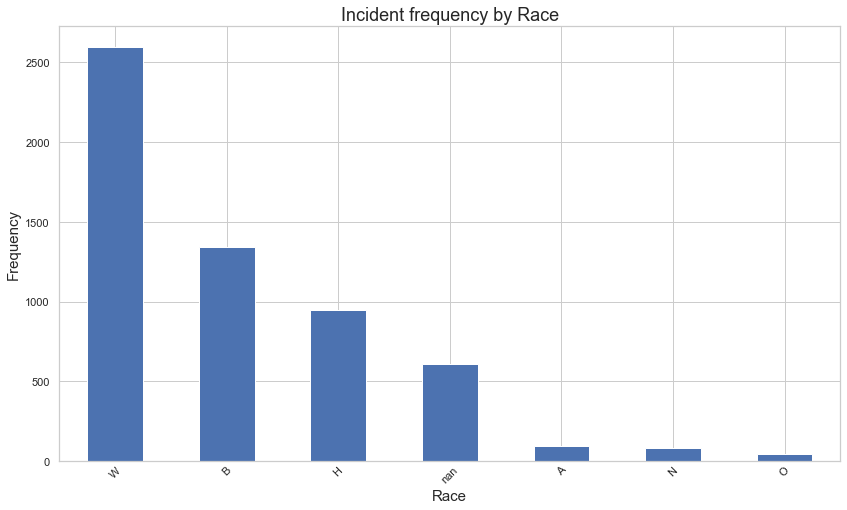

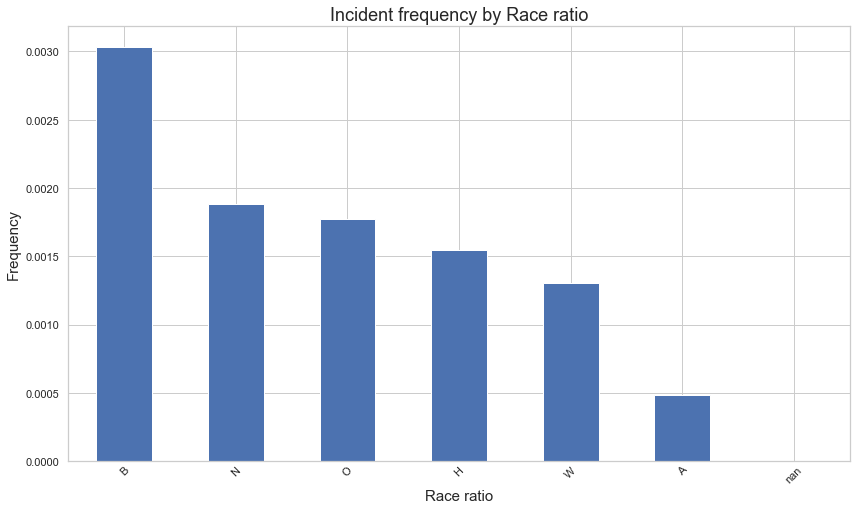

In [46]:
# Get weighted values
df_by_race = df2['race'].value_counts()
display(df_by_race.head())

# https://www.worldometers.info/world-population/us-population
total_pop = 331002651

# Add the weighted race values from wikipedia x populatio
race_ratios = pd.Series({
    'W': 0.601,
    'B': 0.134,
    'A': 0.059,
    'N': 0.013,
    'H': 0.185,
    'O': 0.008,
}) * total_pop

# print(race_ratios)

# Divide the indicent counts by their representation amount 
df_by_race_ratio = (df_by_race/race_ratios) * 100
display(df_by_race_ratio.head())


# Plot state by race
plot_value_counts_barchart(df2, 'race')

# Indicent plot by ratio race in US 
df_by_race_ratio.sort_values(ascending=False, inplace=True)
plot_value_counts_barchart(df2, 'Race ratio', is_custom=True, custom_values=df_by_race_ratio)



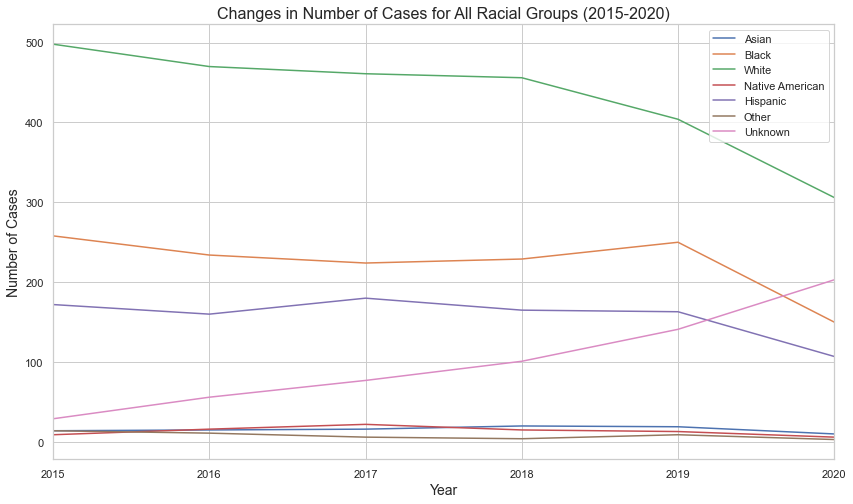

In [47]:
race_year_df = df2.groupby(['race','year'], as_index=False).count()
plt.figure(figsize=(14,8))
plt.plot(race_year_df[race_year_df['race']=='A']['year'],race_year_df[race_year_df['race']=='A']['id'], label='Asian')
plt.plot(race_year_df[race_year_df['race']=='B']['year'],race_year_df[race_year_df['race']=='B']['id'], label='Black')
plt.plot(race_year_df[race_year_df['race']=='W']['year'],race_year_df[race_year_df['race']=='W']['id'], label='White')
plt.plot(race_year_df[race_year_df['race']=='N']['year'],race_year_df[race_year_df['race']=='N']['id'], label='Native American')
plt.plot(race_year_df[race_year_df['race']=='H']['year'],race_year_df[race_year_df['race']=='H']['id'], label='Hispanic')
plt.plot(race_year_df[race_year_df['race']=='O']['year'],race_year_df[race_year_df['race']=='O']['id'], label='Other')
plt.plot(race_year_df[race_year_df['race']=='nan']['year'],race_year_df[race_year_df['race']=='nan']['id'], label='Unknown')
plt.xlim(2015,2020)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Cases", fontsize=14)
plt.title("Changes in Number of Cases for All Racial Groups (2015-2020)", fontsize=16)
plt.legend()
plt.show()

### Incidents by age


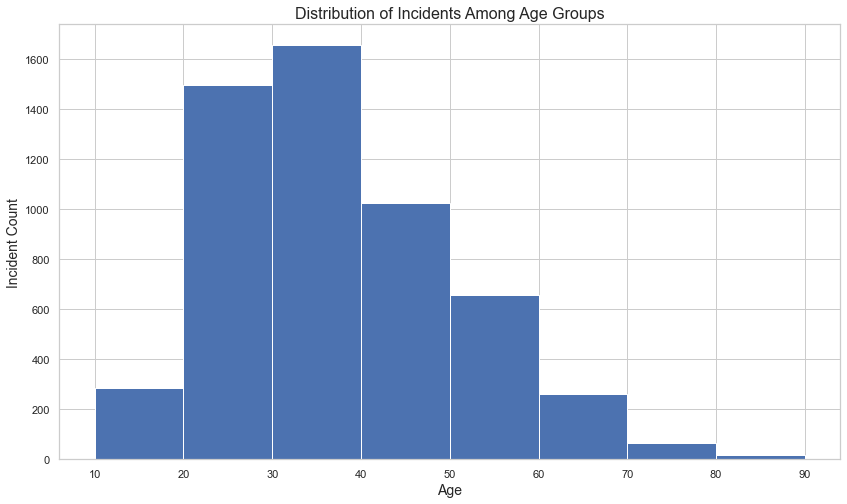

In [48]:
plt.figure(figsize=(14,8))
plt.hist(df2['age'],bins=range(10,100,10))
plt.xlabel("Age", fontsize=14)
plt.ylabel("Incident Count", fontsize=14)
plt.title("Distribution of Incidents Among Age Groups", fontsize=16)
plt.show()


### Creating a mapped visualzation


#### The state of our visualizations
We create a US map so we can better inspect where these indicents occur. We only just started working with geopandas and all it's required depencies, so our visualizations are not that great yet. We do however plan to make more specific state based visualizations, which we can use to inspect where incidents most occur and determine is a precictor like 'urban' can be of importance.

#### Imputing missing coordinates
We miss about 600 latitude and longituge points from are dataset, which you can see in this notebook. So for now we did not use the rows with missing coordinates. We do however plan to impute these coordinates by the coordinates we can cross reference from each corresponding city. This means we'll have can reduce these 600 missing coordinates to 0, since no incident has a missing value for city. We plan to use [geopy](https://geopy.readthedocs.io/en/stable/) for this.

In [49]:
# Right way to install geopands in existing conda env
# Had to do it with pip, alse needed pip install descartes
# https://stackoverflow.com/questions/34427788/how-to-successfully-install-pyproj-and-geopandas
import geopandas

# Create a new df withouth the rows that miss the required rows for mapping
df_wsp_coord_cleared = df2[df2.longitude.notnull()]

# A GeoDataFrame needs a shapely object. We use geopandas points_from_xy()
# to transform Longitude and Latitude into a list of shapely.Point
gdf = geopandas.GeoDataFrame(df_wsp_coord_cleared,
                             geometry=geopandas.points_from_xy(df_wsp_coord_cleared.longitude,
                                                               df_wsp_coord_cleared.latitude))
# Output the results for inspection
display(gdf.head())

,id,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_lat_long,city_density,urban,year,party,geometry
0,3,2015-01-02,shot,gun,53.0,M,A,WA,WA,1,attack,Not fleeing,False,-123.122,47.247,True,Shelton,708.0,suburban,2015,1,POINT (-123.12200 47.24700)
1,4,2015-01-02,shot,gun,47.0,M,W,OR,OR,0,attack,Not fleeing,False,-122.892,45.487,True,Aloha,2915.0,urban,2015,1,POINT (-122.89200 45.48700)
2,5,2015-01-03,shot and Tasered,unarmed,23.0,M,H,KS,KS,0,other,Not fleeing,False,-97.281,37.695,True,Wichita,931.0,suburban,2015,0,POINT (-97.28100 37.69500)
3,8,2015-01-04,shot,toy weapon,32.0,M,W,CA,CA,1,attack,Not fleeing,False,-122.422,37.763,True,Mission District,7256.0,urban,2015,1,POINT (-122.42200 37.76300)
4,9,2015-01-04,shot,nail gun,39.0,M,H,CO,CO,0,attack,Not fleeing,False,-104.692,40.384,True,Evans,804.0,suburban,2015,1,POINT (-104.69200 40.38400)


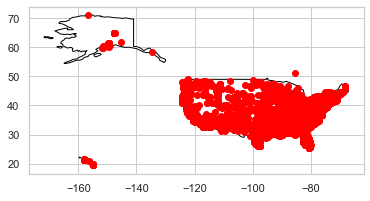

In [50]:
# Docs:https://geopandas.org/gallery/create_geopandas_from_pandas.html
# Other source:https://jcutrer.com/python/learn-geopandas-plotting-usmaps
# https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
# Get the dataset for the naturalearth_lowres
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to US.
ax = world[world.name == "United States of America"].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

# Output our first simple US map
plt.show()

#### Additional Investigative visualizations

Variety of plots attempting to gain further insights into the data


Index(['id', 'date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact', 'city_lat_long', 'city_density', 'urban', 'year', 'party'], dtype='object')


<AxesSubplot:xlabel='flee'>

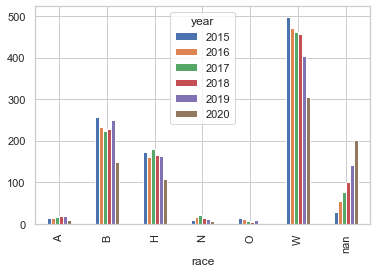

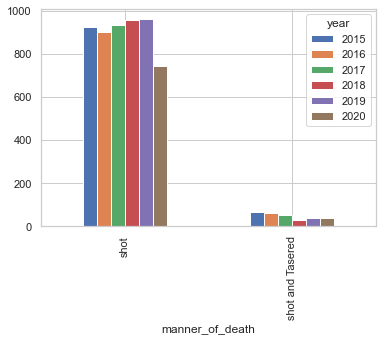

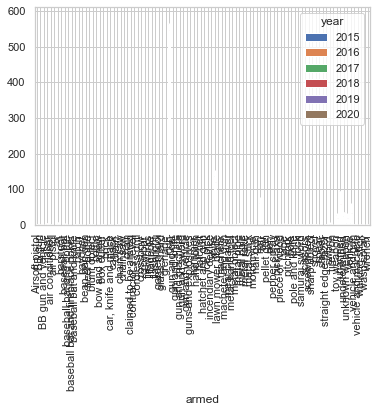

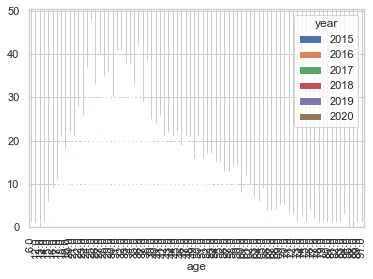

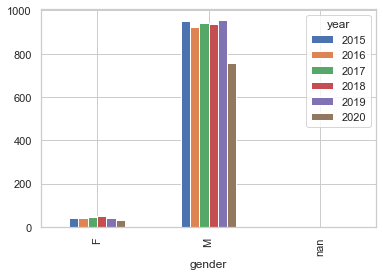

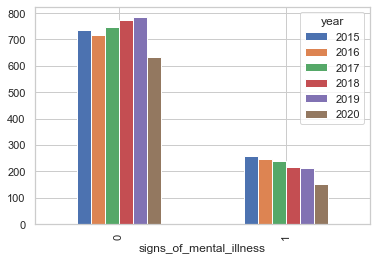

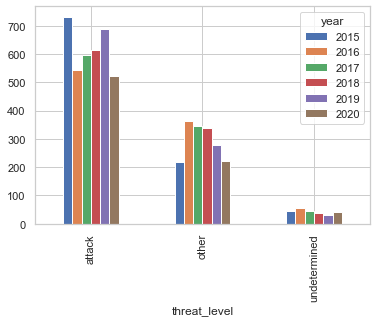

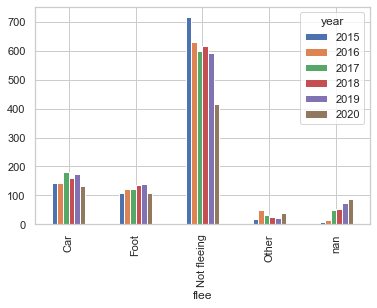

In [51]:
# your code here
print(df2.columns)

df2.groupby('year').race.value_counts().unstack(0).plot.bar()
df2.groupby('year').manner_of_death.value_counts().unstack(0).plot.bar()
df2.groupby('year').armed.value_counts().unstack(0).plot.bar()
df2.groupby('year').age.value_counts().unstack(0).plot.bar()
df2.groupby('year').gender.value_counts().unstack(0).plot.bar()
df2.groupby('year').signs_of_mental_illness.value_counts().unstack(0).plot.bar()
df2.groupby('year').threat_level.value_counts().unstack(0).plot.bar()
df2.groupby('year').flee.value_counts().unstack(0).plot.bar()

Index(['Victim's age', 'Victim's gender', 'Victim's race', 'Date of Incident (month/day/year)', 'City', 'State', 'Zipcode', 'County', 'Agency responsible for death', 'Cause of death', 'Official disposition of death (justified or other)', 'Criminal Charges?', 'Symptoms of mental illness?', 'Unarmed/Did Not Have an Actual Weapon', 'Alleged Weapon', 'Alleged Threat Level (Source: WaPo)', 'Fleeing (Source: WaPo)', 'Body Camera (Source: WaPo)', 'WaPo ID (If included in WaPo database)', 'geography', 'MPV ID', 'Fatal Encounters ID', 'Criminal Charges?_bool', 'Symptoms of mental illness?_bool', 'Unarmed/Did Not Have an Actual Weapon_bool', 'Fleeing (Source: WaPo)_bool', 'Body Camera (Source: WaPo)_bool', 'year', 'party'], dtype='object')


<AxesSubplot:xlabel='Fleeing (Source: WaPo)'>

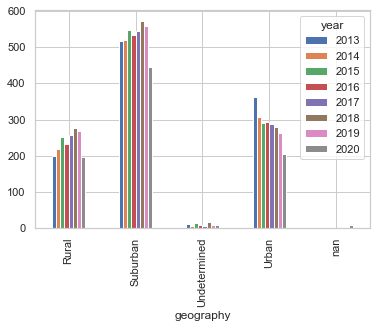

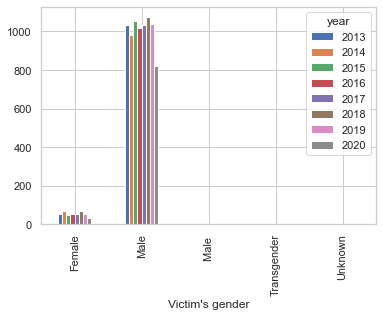

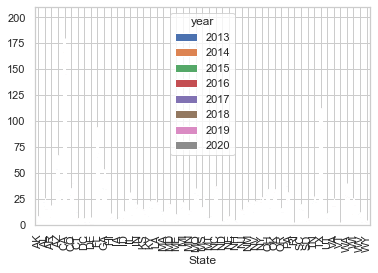

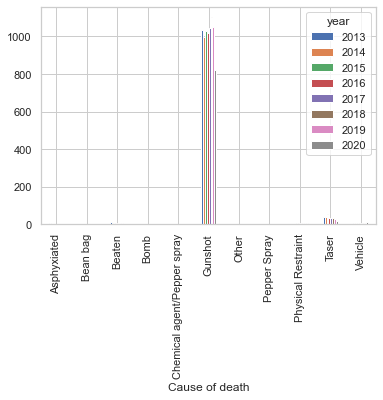

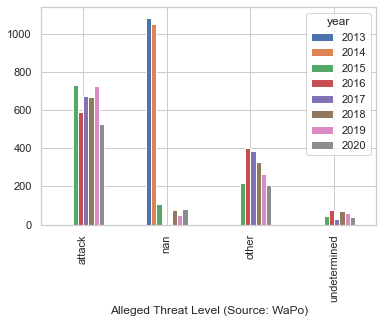

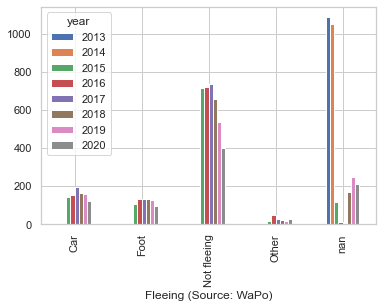

In [52]:
# your code here

print(df1.columns)
# More groupings 
df1.groupby('year').geography.value_counts().unstack(0).plot.bar()
df1.groupby('year')["Victim's gender"].value_counts().unstack(0).plot.bar()
df1.groupby('year')["State"].value_counts().unstack(0).plot.bar()
df1.groupby('year')["Cause of death"].value_counts().unstack(0).plot.bar()
df1.groupby('year')["Alleged Threat Level (Source: WaPo)"].value_counts().unstack(0).plot.bar()
df1.groupby('year')["Fleeing (Source: WaPo)"].value_counts().unstack(0).plot.bar()


<AxesSubplot:>

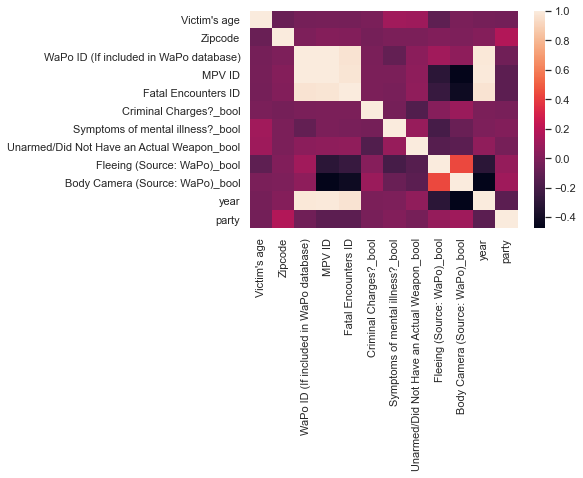

In [53]:
# your code here

# Calculate correlations
corr = df1.corr()
 
# Heatmap
sns.heatmap(corr)

<AxesSubplot:>

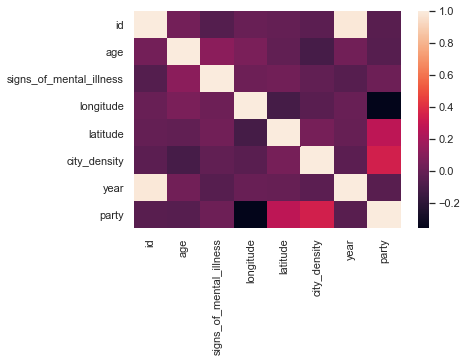

In [54]:
# your code here

# Calculate correlations
corr = df2.corr()
 
# Heatmap
sns.heatmap(corr)


### <div class='exercise'><b>Section 4: Initial Look at Models</b></div>
[▲ Return to contents](#Contents)

<div class='exercise'>

</div>



*This initial look at the models explores the regression specification for Modified Question #2, evaluated by racial category of police shooting victim*

In [55]:
# For our model, we need the distribution of racial groups in each state.  
# To get this data, we downloaded a CSV file from the following URL,
# based on the 2019 estimates by the US Census Bureau.

# https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D 

In [56]:
racial_dist_df = pd.read_csv(f'{data_dir}/raw_data.csv')
# Drop US and PR
racial_dist_df.drop(index=[0,52], inplace=True)
racial_dist_df['state'] = racial_dist_df['Location'].map(us_state_abbrev)
racial_dist_df.set_index('state',inplace=True)
racial_dist_df = racial_dist_df.replace(np.nan,0)
racial_dist_df = racial_dist_df.replace('<.01',0)
racial_dist_df['Native Hawaiian/Other Pacific Islander'] = racial_dist_df['Native Hawaiian/Other Pacific Islander'].astype(float)
racial_dist_df['other'] = racial_dist_df['Native Hawaiian/Other Pacific Islander'] + racial_dist_df['Multiple Races']
racial_dist_df = racial_dist_df.rename(columns={'White':'race_W_ratio', 'Black': 'race_B_ratio', 'Hispanic': 'race_H_ratio', 'Asian': 'race_A_ratio', 'American Indian/Alaska Native': 'race_N_ratio', 'other': 'race_O_ratio'})

In [57]:
model_df = pd.get_dummies(data=df2[['year','race','state']], columns=['race'])
model_df = model_df.groupby(['state','year'], as_index=False).sum()
model_df['total_incidents'] = model_df.race_A + model_df.race_B + model_df.race_H + model_df.race_N + model_df.race_O + model_df.race_W + model_df.race_nan
model_df = model_df.join(population_summary['POPESTIMATE2019'], on='state')
model_df = model_df.join(racial_dist_df[['race_W_ratio','race_B_ratio','race_H_ratio','race_A_ratio','race_N_ratio','race_O_ratio']], on='state')
model_df['black_inc_per_pop'] = model_df['race_B'] / (model_df['POPESTIMATE2019'] * model_df['race_B_ratio'])
model_df['white_inc_per_pop'] = model_df['race_W'] / (model_df['POPESTIMATE2019'] * model_df['race_W_ratio'])
model_df['asian_inc_per_pop'] = model_df['race_A'] / (model_df['POPESTIMATE2019'] * model_df['race_A_ratio'])
model_df['native_inc_per_pop'] = model_df['race_N'] / (model_df['POPESTIMATE2019'] * model_df['race_N_ratio'])
model_df['hispanic_inc_per_pop'] = model_df['race_H'] / (model_df['POPESTIMATE2019'] * model_df['race_H_ratio'])
model_df['other_inc_per_pop'] = model_df['race_O'] / (model_df['POPESTIMATE2019'] * model_df['race_O_ratio'])
model_df.head(10)

,state,year,race_A,race_B,race_H,race_N,race_O,race_W,race_nan,total_incidents,POPESTIMATE2019,race_W_ratio,race_B_ratio,race_H_ratio,race_A_ratio,race_N_ratio,race_O_ratio,black_inc_per_pop,white_inc_per_pop,asian_inc_per_pop,native_inc_per_pop,hispanic_inc_per_pop,other_inc_per_pop
0,AK,2015,0,0,0,2,0,2,0,4,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000000,0.000005,0.000000,0.000018,0.000000,0.0
1,AK,2016,0,0,0,3,0,3,1,7,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000000,0.000007,0.000000,0.000027,0.000000,0.0
2,AK,2017,0,1,0,1,0,5,1,8,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000062,0.000011,0.000000,0.000009,0.000000,0.0
3,AK,2018,1,1,0,2,0,3,0,7,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000062,0.000007,0.000023,0.000018,0.000000,0.0
4,AK,2019,0,1,0,1,0,4,1,7,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000062,0.000009,0.000000,0.000009,0.000000,0.0
5,AK,2020,1,0,0,0,0,5,1,7,731545,0.600,0.022,0.070,0.060,0.151,0.098,0.000000,0.000011,0.000023,0.000000,0.000000,0.0
6,AL,2015,0,6,0,0,0,11,0,17,4903185,0.654,0.265,0.044,0.014,0.004,0.019,0.000005,0.000003,0.000000,0.000000,0.000000,0.0
7,AL,2016,0,6,0,0,0,17,2,25,4903185,0.654,0.265,0.044,0.014,0.004,0.019,0.000005,0.000005,0.000000,0.000000,0.000000,0.0
8,AL,2017,0,6,1,0,0,14,4,25,4903185,0.654,0.265,0.044,0.014,0.004,0.019,0.000005,0.000004,0.000000,0.000000,0.000005,0.0
9,AL,2018,0,3,0,0,0,9,1,13,4903185,0.654,0.265,0.044,0.014,0.004,0.019,0.000002,0.000003,0.000000,0.000000,0.000000,0.0


In [58]:
# your code here
from linearmodels import PanelOLS
import statsmodels.formula.api as smf

In [59]:
# your code here
model_black = smf.ols(formula='black_inc_per_pop ~ 1 + C(state) + C(year)', data = model_df).fit()
print(model_black.summary())

                            OLS Regression Results                            
Dep. Variable:      black_inc_per_pop   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     2.754
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           5.57e-08
Time:                        21:25:14   Log-Likelihood:                 3020.3
No. Observations:                 298   AIC:                            -5929.
Df Residuals:                     242   BIC:                            -5721.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.061e-05   4.56e-06     

In [60]:
# your code here
model_white = smf.ols(formula='white_inc_per_pop ~ 1 + C(state) + C(year)', data = model_df).fit()
print(model_white.summary())

                            OLS Regression Results                            
Dep. Variable:      white_inc_per_pop   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     7.783
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           2.98e-30
Time:                        21:25:14   Log-Likelihood:                 3633.7
No. Observations:                 298   AIC:                            -7155.
Df Residuals:                     242   BIC:                            -6948.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        8.685e-06   5.82e-07     

In [61]:
# your code here
model_hispanic = smf.ols(formula='hispanic_inc_per_pop ~ 1 + C(state) + C(year) ', data = model_df).fit()
print(model_hispanic.summary())

                             OLS Regression Results                             
Dep. Variable:     hispanic_inc_per_pop   R-squared:                       0.375
Model:                              OLS   Adj. R-squared:                  0.233
Method:                   Least Squares   F-statistic:                     2.643
Date:                  Fri, 04 Dec 2020   Prob (F-statistic):           1.92e-07
Time:                          21:25:14   Log-Likelihood:                 3363.5
No. Observations:                   298   AIC:                            -6615.
Df Residuals:                       242   BIC:                            -6408.
Df Model:                            55                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -6.438

In [62]:
# your code here
model_otherrace = smf.ols(formula='other_inc_per_pop ~ 1 + C(state) + C(year)', data = model_df).fit()
print(model_otherrace.summary())

                            OLS Regression Results                            
Dep. Variable:      other_inc_per_pop   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     1.541
Date:                Fri, 04 Dec 2020   Prob (F-statistic):             0.0147
Time:                        21:25:14   Log-Likelihood:                 3438.1
No. Observations:                 298   AIC:                            -6764.
Df Residuals:                     242   BIC:                            -6557.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         1.89e-07   1.12e-06     

*Your answer here*  


### <div class='exercise'><b>Section 5: Extending The Models Further</b></div>
[▲ Return to contents](#Contents)
<div class='exercise'>

</div>


This section will investigate additional models using the Washington Post dataset.

#### Models
 * Logistic Regression baseline
 * Polynomial Features (3rd order) Regression
 * Lasso Regularized Model
 * Random Forest
 * Neural Net
 
#### attempts:
1. Predict race based on all other WaPo predictors. 
2. Predict mental illness based on other WaPo predictors.
3. Predict justification of shootings with police violence predictors




In [63]:
# do we have any null values?
df2.isnull().values.any()
print("Null values in the Dataset:")

# where are they?
for col in df2.columns:
    null_count = df2[col].isnull().sum()
    print(col, ": ", null_count)
    
# Only a few missing values, lets drop those
df2 = df2.dropna()
print("\n\nModified dataframe shape after dropping NaN:")
display(df2.shape)

Null values in the Dataset:
id :  0
date :  0
manner_of_death :  0
armed :  0
age :  260
gender :  0
race :  0
city :  0
state :  0
signs_of_mental_illness :  0
threat_level :  0
flee :  0
body_camera :  0
longitude :  279
latitude :  279
is_geocoding_exact :  0
city_lat_long :  0
city_density :  0
urban :  0
year :  0
party :  0


Modified dataframe shape after dropping NaN:


(5198, 21)

In [64]:
display(df2.head())

from sklearn.preprocessing import LabelEncoder
# preprocess categorical
cat_vars = ['manner_of_death','armed', 'gender', 'race', 'city', 'state', 'threat_level', 
            'flee', 'body_camera', 'is_geocoding_exact', 'urban', 'year']

le = LabelEncoder()
mapping = {}

# Assigning numerical values and storing in another column
for var in cat_vars:
    
    # transform categorical
    df2[var] = le.fit_transform(df2[var])
    
    # verify mappings for later filtering
    mapping[var] = dict(zip(le.classes_, le.transform(le.classes_)))

# mapping?
print("Mapping:")
print(mapping)


,id,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_lat_long,city_density,urban,year,party
0,3,2015-01-02,shot,gun,53.0,M,A,WA,WA,1,attack,Not fleeing,False,-123.122,47.247,True,Shelton,708.0,suburban,2015,1
1,4,2015-01-02,shot,gun,47.0,M,W,OR,OR,0,attack,Not fleeing,False,-122.892,45.487,True,Aloha,2915.0,urban,2015,1
2,5,2015-01-03,shot and Tasered,unarmed,23.0,M,H,KS,KS,0,other,Not fleeing,False,-97.281,37.695,True,Wichita,931.0,suburban,2015,0
3,8,2015-01-04,shot,toy weapon,32.0,M,W,CA,CA,1,attack,Not fleeing,False,-122.422,37.763,True,Mission District,7256.0,urban,2015,1
4,9,2015-01-04,shot,nail gun,39.0,M,H,CO,CO,0,attack,Not fleeing,False,-104.692,40.384,True,Evans,804.0,suburban,2015,1


Mapping:
{'manner_of_death': {'shot': 0, 'shot and Tasered': 1}, 'armed': {'Airsoft pistol': 0, 'BB gun': 1, 'BB gun and vehicle': 2, 'Taser': 3, 'air conditioner': 4, 'air pistol': 5, 'ax': 6, 'barstool': 7, 'baseball bat': 8, 'baseball bat and bottle': 9, 'baseball bat and fireplace poker': 10, 'baton': 11, 'bayonet': 12, 'bean-bag gun': 13, 'beer bottle': 14, 'blunt object': 15, 'bottle': 16, 'bow and arrow': 17, 'box cutter': 18, 'brick': 19, 'carjack': 20, 'chain': 21, 'chain saw': 22, 'chainsaw': 23, 'chair': 24, 'claimed to be armed': 25, "contractor's level": 26, 'cordless drill': 27, 'crossbow': 28, 'crowbar': 29, 'fireworks': 30, 'flagpole': 31, 'flashlight': 32, 'garden tool': 33, 'glass shard': 34, 'grenade': 35, 'gun': 36, 'gun and car': 37, 'gun and knife': 38, 'gun and machete': 39, 'gun and sword': 40, 'gun and vehicle': 41, 'guns and explosives': 42, 'hammer': 43, 'hand torch': 44, 'hatchet': 45, 'hatchet and gun': 46, 'ice pick': 47, 'incendiary device': 48, 'knife': 

In [65]:
# First need to redefine and split the data into train and test sets

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier


# initialize
test_size = 0.2
random_state=42
# columns
# ['id', 'date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 
# 'threat_level', 'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact']

# set X without response or unused predictors
X = df2.drop(['id', 'date', 'race', 'city', 'is_geocoding_exact', 'latitude', 'longitude', 'city_lat_long'], axis=1)
y = df2['race']


# Split train and test data
X_train, X_test, y_train, y_test  = train_test_split(X, 
                                                     y, 
                                                     test_size=test_size, 
                                                     random_state = random_state,
                                                     )

print("Initial Dataframe shape: ", df2.shape)
print("X_train shape: ", X_train.shape, "\nX_test shape: ", X_test.shape, "\ny_train shape: ", y_train.shape, "\ny_test shape: ", y_test.shape)


Initial Dataframe shape:  (5198, 21)
X_train shape:  (4158, 13) 
X_test shape:  (1040, 13) 
y_train shape:  (4158,) 
y_test shape:  (1040,)


In [66]:
# logistic regression model with L2 ridge regularization
logreg = LogisticRegression(penalty='l2',  
                            max_iter=2000,
                            C=1.0)

# fit on scaled training data
logreg.fit(X_train,y_train)

# Check accuracy score
logreg_train_accuracy = logreg.score(X_train, y_train)*100
logreg_test_accuracy = logreg.score(X_test, y_test)*100

# Print results
print("Ridge Model Accuracy Results:")
print(f'  Logisitic Train Accuracy: {logreg_train_accuracy:.2f}%')
print(f'  Logisitic Test Accuracy: {logreg_test_accuracy:.2f}%')


Ridge Model Accuracy Results:
  Logisitic Train Accuracy: 53.10%
  Logisitic Test Accuracy: 53.27%


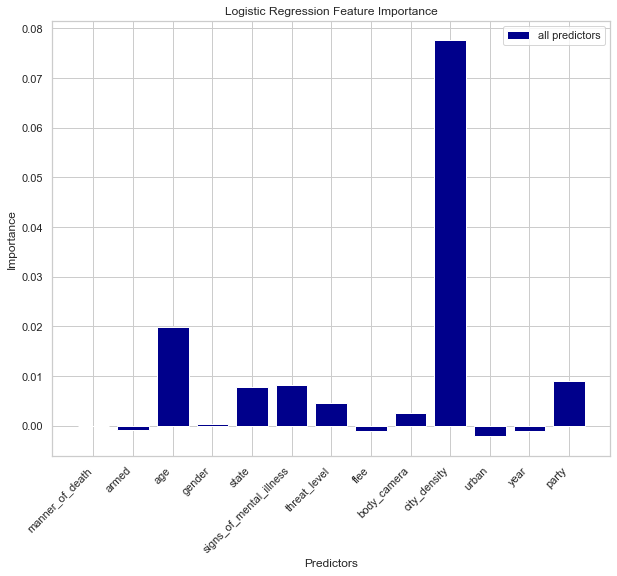

In [67]:
# find predictors
importance = permutation_importance(logreg,
                                    X_train,
                                    y_train,
                                    n_repeats=5
                                   )

# take top 10
#importance = np.sort(importance)[:10]
cols = X.columns

# summarize feature importance
#for i,v in enumerate(importance.importances_mean):
#    print(f'Feature {i}: {cols[i]}   Score: {v:.4f}')

# plot feature importance
fig = plt.figure(figsize=(10,8))
plt.bar([x for x in range(len(importance.importances_mean))], importance.importances_mean, color='darkblue', label='all predictors')
plt.title('Logistic Regression Feature Importance')
plt.xticks(np.arange(len(cols)), cols, rotation=45, horizontalalignment='right')
plt.ylabel('Importance')
plt.xlabel('Predictors')
plt.legend()
plt.show()

In [68]:
# predict using test set
y_pred_test = logreg.predict(X_test)
y_pred_wh = logreg.predict(X_test[y_test==0])
y_pred_bl = logreg.predict(X_test[y_test==1])
y_pred_2 = logreg.predict(X_test[y_test==2])
y_pred_3 = logreg.predict(X_test[y_test==3])
y_pred_4 = logreg.predict(X_test[y_test==4])

# get performance by class
print('\nOverall Test Set Performance')
cm1 = pd.crosstab(y_test, 
                  y_pred_test, 
                  margins=True, 
                  rownames=['Actual'], 
                  colnames=['Predicted'])
display(cm1)


Overall Test Set Performance


Predicted,1,2,5,6,All
Actual,,,,,
0,3,4,11,1,19
1,88,18,158,0,264
2,36,35,121,3,195
3,1,1,13,0,15
4,1,0,9,0,10
5,31,10,427,4,472
6,5,4,52,4,65
All,165,72,791,12,1040


In [69]:
# Try polynomial features up to 3rd order polynomials
degree = 3

# define data
X_train_poly = PolynomialFeatures(degree=degree,
                                  include_bias=False).fit_transform(X_train)
X_test_poly = PolynomialFeatures(degree=degree,
                                 include_bias=False).fit_transform(X_test)
# fit model
polyreg3 = LogisticRegression(penalty='none', 
                              max_iter = 5000).fit(X_train_poly, y_train)

# Check accuracy score
polyreg3_train_accuracy = polyreg3.score(X_train_poly, y_train)*100
polyreg3_test_accuracy = polyreg3.score(X_test_poly, y_test)*100

# Print results
print("Polynomial Features Logistic Regression Model Accuracy Results:")
print(f'  Logisitic Train Accuracy with 3rd Order Polynomial Features: {polyreg3_train_accuracy:.2f}%')
print(f'  Logisitic Test Accuracy with 3rd Order Polynomial Features: {polyreg3_test_accuracy:.2f}%')

Polynomial Features Logistic Regression Model Accuracy Results:
  Logisitic Train Accuracy with 3rd Order Polynomial Features: 50.99%
  Logisitic Test Accuracy with 3rd Order Polynomial Features: 51.83%


In [70]:
# Try Regularized Model
# Best model based on cross validation accuracy
c = 1

# generate model
logit_lasso = LogisticRegression(C=c, 
                                 penalty='l1', 
                                 solver='saga', 
                                 max_iter = 5000).fit(X_train, y_train)

#Perfromance Evaluation
logit_lasso_train_accuracy = logit_lasso.score(X_train, y_train)*100
logit_lasso_test_accuracy = logit_lasso.score(X_test, y_test)*100

# Beta Values
intercept = logit_lasso.intercept_[0]
betas = logit_lasso.coef_[0]

# Print results
print("Best (C=100) Lasso Model Estimated Coefficients:")
print(f'Intercept: {intercept:.4f}')
#for idx, val in enumerate(betas):
    #print(f'Beta {idx+1} value: {val:.4f}')
print(f'Best Lasso Train Accuracy: {logit_lasso_train_accuracy:.2f}%')
print(f'Best Lasso Test Accuracy: {logit_lasso_test_accuracy:.2f}%')

Best (C=100) Lasso Model Estimated Coefficients:
Intercept: -0.0006
Best Lasso Train Accuracy: 51.92%
Best Lasso Test Accuracy: 51.54%


In [71]:
# initialize
tree_depth = 10
seed = 0
n_estimators = 55

random_forest = RandomForestClassifier(max_depth=tree_depth, 
                                       #random_state=seed,
                                       max_features='sqrt',
                                       n_estimators=n_estimators)

# Fit the model on the training set
random_forest.fit(X_train, y_train)

# scores
random_forest_train_accuracy = random_forest.score(X_train, y_train)*100
random_forest_test_accuracy = random_forest.score(X_test, y_test)*100

# print results
print(f'Random Forest Train Accuracy: {random_forest_train_accuracy:.2f}%')
print(f'Random Forest Test Accuracy: {random_forest_test_accuracy:.2f}%')

Random Forest Train Accuracy: 70.39%
Random Forest Test Accuracy: 55.38%


In [72]:
# try neural net

# couple extra imports
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# initialize
# The number of nodes in a hidden layer
n_hidden = 15
# The number of nodes in the input layer (features)
n_input = len(X_train.columns)
# The number of nodes in the output layer
n_output = 1

# First we instantiate a Keras model
NN_model = models.Sequential(name='ANN')

# Adding Layers
NN_model.add(layers.Dense(n_hidden, 
                          activation='relu', 
                          input_shape=[n_input,], 
                          name='hidden1'))
NN_model.add(layers.Dense(n_hidden, 
                          activation='relu',  
                          name='hidden2'))

# Now add the output layer
NN_model.add(layers.Dense(n_output, 
                          activation='sigmoid',  
                          name='output'))

# initialize
epochs = 200

# Compilation
NN_model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

#View model summary
display(NN_model.summary())

#Fit the model on the training data
NN_model.fit(X_train, 
             y_train, 
             epochs=epochs,
             verbose=0,
             validation_split=0.2)

# evaluate
NN_train_accuracy = NN_model.evaluate(X_train,y_train)[1]*100
NN_test_accuracy = NN_model.evaluate(X_test,y_test)[1]*100

# print results
print(f'\nThe training set accuracy for the model is: {NN_train_accuracy:.2f}%')
print(f'The test set accuracy for the model is: {NN_test_accuracy:.2f}%')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 15)                210       
_________________________________________________________________
hidden2 (Dense)              (None, 15)                240       
_________________________________________________________________
output (Dense)               (None, 1)                 16        
Total params: 466
Trainable params: 466
Non-trainable params: 0
_________________________________________________________________


None

1040/1040 [==============================] - 0s 73us/sample - loss: -4209141917.5385 - acc: 0.2538

The training set accuracy for the model is: 24.19%
The test set accuracy for the model is: 25.38%


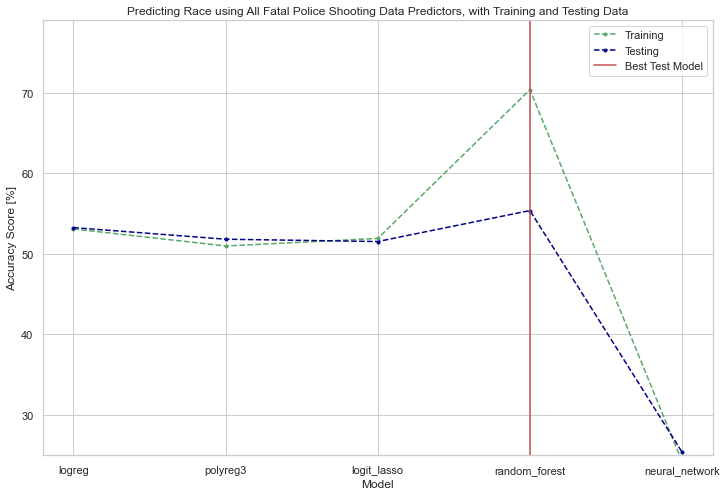

In [73]:
# compare various models
acc_dict_train = {'logreg': logreg_train_accuracy,
                  'polyreg3': polyreg3_train_accuracy,
                  'logit_lasso': logit_lasso_train_accuracy,
                  'random_forest': random_forest_train_accuracy, 
                  'neural_network': NN_train_accuracy
                 }
acc_dict_test = {'logreg': logreg_test_accuracy,
                 'polyreg3': polyreg3_test_accuracy,
                 'logit_lasso': logit_lasso_test_accuracy,
                 'random_forest': random_forest_test_accuracy,
                 'neural_network': NN_test_accuracy
                 }


# Look at our projections so far
X = np.arange(len(acc_dict_train))

fig = plt.figure(figsize=(12,8))
plt.plot(X, acc_dict_train.values(), '--.', color='g', label="Training")
plt.plot(X, acc_dict_test.values(), '--.', color='darkblue', label='Testing')
plt.title('Predicting Race using All Fatal Police Shooting Data Predictors, with Training and Testing Data')
plt.axvline(3, 0, 100, color = 'r', label = f'Best Test Model')
plt.xlabel('Model')
plt.ylabel('Accuracy Score [%]')
plt.xticks(X, acc_dict_train.keys())
plt.ylim(25,79)
plt.legend()
plt.show()

### Attempt 2


#### Predicting Race was no better than a coin flip
All of the above models were marginal at best, displaying no clear relationship between predictors and race

#### Moving on to Predicting Mental Illness
I'm really interested in understanding how mental illness factors into these crimes and subsequent shootings.



In [74]:
# initialize
test_size = 0.2
random_state=42
# columns
# ['id', 'date', 'manner_of_death', 'armed', 'age', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 
# 'threat_level', 'flee', 'body_camera', 'longitude', 'latitude', 'is_geocoding_exact']

# set X without response or unused predictors
X = df2.drop(['id', 'date', 'city', 'signs_of_mental_illness', 'is_geocoding_exact', 'latitude', 'longitude', 'city_lat_long'], axis=1)
y = df2['signs_of_mental_illness']


# Split train and test data
X_train, X_test, y_train, y_test  = train_test_split(X, 
                                                     y, 
                                                     test_size=test_size, 
                                                     random_state = random_state,
                                                     )

print("Initial Dataframe shape: ", df2.shape)
print("X_train shape: ", X_train.shape, "\nX_test shape: ", X_test.shape, "\ny_train shape: ", y_train.shape, "\ny_test shape: ", y_test.shape)


Initial Dataframe shape:  (5198, 21)
X_train shape:  (4158, 13) 
X_test shape:  (1040, 13) 
y_train shape:  (4158,) 
y_test shape:  (1040,)


In [75]:
# logistic regression model with L2 ridge regularization
logreg = LogisticRegression(penalty='l2',  
                            max_iter=2000,
                            C=1.0)

# fit on scaled training data
logreg.fit(X_train,y_train)

# Check accuracy score
logreg_train_accuracy = logreg.score(X_train, y_train)*100
logreg_test_accuracy = logreg.score(X_test, y_test)*100

# Print results
print("Ridge Model Accuracy Results:")
print(f'  Logisitic Train Accuracy: {logreg_train_accuracy:.2f}%')
print(f'  Logisitic Test Accuracy: {logreg_test_accuracy:.2f}%')

Ridge Model Accuracy Results:
  Logisitic Train Accuracy: 76.89%
  Logisitic Test Accuracy: 75.29%


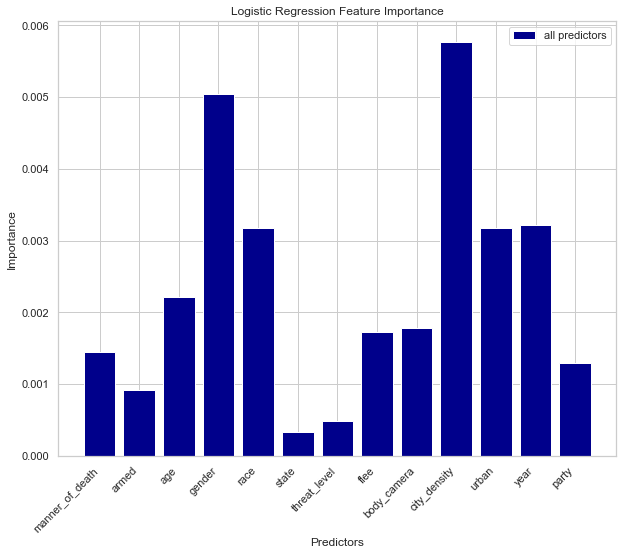

In [76]:
# find predictors
importance = permutation_importance(logreg,
                                    X_train,
                                    y_train,
                                    n_repeats=5
                                   )

# take top 10
#importance = np.sort(importance)[:10]
cols = X.columns

# summarize feature importance
#for i,v in enumerate(importance.importances_mean):
#    print(f'Feature {i}: {cols[i]}   Score: {v:.4f}')

# plot feature importance
fig = plt.figure(figsize=(10,8))
plt.bar([x for x in range(len(importance.importances_mean))], importance.importances_mean, color='darkblue', label='all predictors')
plt.title('Logistic Regression Feature Importance')
plt.xticks(np.arange(len(cols)), cols, rotation=45, horizontalalignment='right')
plt.ylabel('Importance')
plt.xlabel('Predictors')
plt.legend()
plt.show()

In [77]:
# predict using test set
y_pred_test = logreg.predict(X_test)
y_pred_wh = logreg.predict(X_test[y_test==0])
y_pred_bl = logreg.predict(X_test[y_test==1])

# get performance by class
print('\nOverall Test Set Performance')
cm1 = pd.crosstab(y_test, 
                  y_pred_test, 
                  margins=True, 
                  rownames=['Actual'], 
                  colnames=['Predicted'])
display(cm1)


Overall Test Set Performance


Predicted,0,1,All
Actual,,,
0,769,10,779
1,247,14,261
All,1016,24,1040


In [78]:
# Try polynomial features up to 3rd order polynomials
degree = 3

# define data
X_train_poly = PolynomialFeatures(degree=degree,
                                  include_bias=False).fit_transform(X_train)
X_test_poly = PolynomialFeatures(degree=degree,
                                 include_bias=False).fit_transform(X_test)
# fit model
polyreg3 = LogisticRegression(penalty='none', 
                              max_iter = 5000).fit(X_train_poly, y_train)

# Check accuracy score
polyreg3_train_accuracy = polyreg3.score(X_train_poly, y_train)*100
polyreg3_test_accuracy = polyreg3.score(X_test_poly, y_test)*100

# Print results
print("Polynomial Features Logistic Regression Model Accuracy Results:")
print(f'  Logisitic Train Accuracy with 3rd Order Polynomial Features: {polyreg3_train_accuracy:.2f}%')
print(f'  Logisitic Test Accuracy with 3rd Order Polynomial Features: {polyreg3_test_accuracy:.2f}%')

Polynomial Features Logistic Regression Model Accuracy Results:
  Logisitic Train Accuracy with 3rd Order Polynomial Features: 76.79%
  Logisitic Test Accuracy with 3rd Order Polynomial Features: 74.52%


In [79]:
# Try Regularized Model
# Best model based on cross validation accuracy
c = 1

# generate model
logit_lasso = LogisticRegression(C=c, 
                                 penalty='l1', 
                                 solver='saga', 
                                 max_iter = 5000).fit(X_train, y_train)

#Perfromance Evaluation
logit_lasso_train_accuracy = logit_lasso.score(X_train, y_train)*100
logit_lasso_test_accuracy = logit_lasso.score(X_test, y_test)*100

# Beta Values
intercept = logit_lasso.intercept_[0]
betas = logit_lasso.coef_[0]

# Print results
print("Best (C=100) Lasso Model Estimated Coefficients:")
print(f'Intercept: {intercept:.4f}')
#for idx, val in enumerate(betas):
    #print(f'Beta {idx+1} value: {val:.4f}')
print(f'Best Lasso Train Accuracy: {logit_lasso_train_accuracy:.2f}%')
print(f'Best Lasso Test Accuracy: {logit_lasso_test_accuracy:.2f}%')

Best (C=100) Lasso Model Estimated Coefficients:
Intercept: -0.0038
Best Lasso Train Accuracy: 76.74%
Best Lasso Test Accuracy: 74.90%


In [80]:
# initialize
tree_depth = 10
seed = 0
n_estimators = 55

random_forest = RandomForestClassifier(max_depth=tree_depth, 
                                       #random_state=seed,
                                       max_features='sqrt',
                                       n_estimators=n_estimators)

# Fit the model on the training set
random_forest.fit(X_train, y_train)

# scores
random_forest_train_accuracy = random_forest.score(X_train, y_train)*100
random_forest_test_accuracy = random_forest.score(X_test, y_test)*100

# print results
print(f'Random Forest Train Accuracy: {random_forest_train_accuracy:.2f}%')
print(f'Random Forest Test Accuracy: {random_forest_test_accuracy:.2f}%')

Random Forest Train Accuracy: 82.64%
Random Forest Test Accuracy: 74.52%


In [81]:
# try neural net

# couple extra imports
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# initialize
# The number of nodes in a hidden layer
n_hidden = 15
# The number of nodes in the input layer (features)
n_input = len(X_train.columns)
# The number of nodes in the output layer
n_output = 1

# First we instantiate a Keras model
NN_model = models.Sequential(name='ANN')

# Adding Layers
NN_model.add(layers.Dense(n_hidden, 
                          activation='relu', 
                          input_shape=[n_input,], 
                          name='hidden1'))
NN_model.add(layers.Dense(n_hidden, 
                          activation='relu',  
                          name='hidden2'))

# Now add the output layer
NN_model.add(layers.Dense(n_output, 
                          activation='sigmoid',  
                          name='output'))

# initialize
epochs = 200

# Compilation
NN_model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

#View model summary
display(NN_model.summary())

#Fit the model on the training data
NN_model.fit(X_train, 
             y_train, 
             epochs=epochs,
             verbose=0,
             validation_split=0.2)

# evaluate
NN_train_accuracy = NN_model.evaluate(X_train,y_train)[1]*100
NN_test_accuracy = NN_model.evaluate(X_test,y_test)[1]*100

# print results
print(f'\nThe training set accuracy for the model is: {NN_train_accuracy:.2f}%')
print(f'The test set accuracy for the model is: {NN_test_accuracy:.2f}%')

Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 15)                210       
_________________________________________________________________
hidden2 (Dense)              (None, 15)                240       
_________________________________________________________________
output (Dense)               (None, 1)                 16        
Total params: 466
Trainable params: 466
Non-trainable params: 0
_________________________________________________________________


None

1040/1040 [==============================] - 0s 45us/sample - loss: 0.5927 - acc: 0.7423

The training set accuracy for the model is: 76.62%
The test set accuracy for the model is: 74.23%


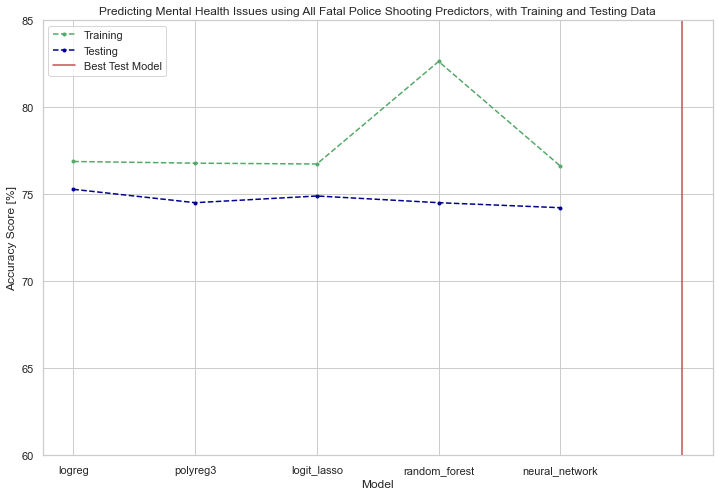

In [82]:
# compare various models
acc_dict_train = {'logreg': logreg_train_accuracy,
                  'polyreg3': polyreg3_train_accuracy,
                  'logit_lasso': logit_lasso_train_accuracy,
                  'random_forest': random_forest_train_accuracy, 
                  'neural_network': NN_train_accuracy
                 }
acc_dict_test = {'logreg': logreg_test_accuracy,
                 'polyreg3': polyreg3_test_accuracy,
                 'logit_lasso': logit_lasso_test_accuracy,
                 'random_forest': random_forest_test_accuracy,
                 'neural_network': NN_test_accuracy
                 }


# Look at our projections so far
X = np.arange(len(acc_dict_train))

fig = plt.figure(figsize=(12,8))
plt.plot(X, acc_dict_train.values(), '--.', color='g', label="Training")
plt.plot(X, acc_dict_test.values(), '--.', color='darkblue', label='Testing')
plt.title('Predicting Mental Health Issues using All Fatal Police Shooting Predictors, with Training and Testing Data')
plt.axvline(0, 0, 100, color = 'r', label = f'Best Test Model')
plt.xlabel('Model')
plt.ylabel('Accuracy Score [%]')
plt.xticks(X, acc_dict_train.keys())
plt.ylim(60,85)
plt.legend()
plt.show()

### Attempt 3


#### Predicting Justification of Violence by Race 
All of the above models were marginal at best, displaying no clear relationship between predictors and race


In [83]:
# preprocess categorical

cat_vars = ["Victim's gender","Victim's race", 'State', 'Cause of death', 
            'Official disposition of death (justified or other)', 'Criminal Charges?', 'Symptoms of mental illness?', 
            'Unarmed/Did Not Have an Actual Weapon', 'Alleged Weapon', 'Alleged Threat Level (Source: WaPo)', 
            'Fleeing (Source: WaPo)', 'Body Camera (Source: WaPo)', 'geography', 'year']

le = LabelEncoder()
mapping = {}

# Assigning numerical values and storing in another column
for var in cat_vars:
    
    # transform categorical
    df1[var] = le.fit_transform(df1[var])
    
    # verify mappings for later filtering
    mapping[var] = dict(zip(le.classes_, le.transform(le.classes_)))

# mapping?
print("Mapping:")
print(mapping)

Mapping:
{"Victim's gender": {'Female': 0, 'Male': 1, 'Male ': 2, 'Transgender': 3, 'Unknown': 4}, "Victim's race": {'Asian': 0, 'Black': 1, 'Hispanic': 2, 'Native American': 3, 'Pacific Islander': 4, 'Unknown race': 5, 'White': 6, 'nan': 7}, 'State': {'AK': 0, 'AL': 1, 'AR': 2, 'AZ': 3, 'CA': 4, 'CO': 5, 'CT': 6, 'DC': 7, 'DE': 8, 'FL': 9, 'GA': 10, 'HI': 11, 'IA': 12, 'ID': 13, 'IL': 14, 'IN': 15, 'KS': 16, 'KY': 17, 'LA': 18, 'MA': 19, 'MD': 20, 'ME': 21, 'MI': 22, 'MN': 23, 'MO': 24, 'MS': 25, 'MT': 26, 'NC': 27, 'ND': 28, 'NE': 29, 'NH': 30, 'NJ': 31, 'NM': 32, 'NV': 33, 'NY': 34, 'OH': 35, 'OK': 36, 'OR': 37, 'PA': 38, 'RI': 39, 'SC': 40, 'SD': 41, 'TN': 42, 'TX': 43, 'UT': 44, 'VA': 45, 'VT': 46, 'WA': 47, 'WI': 48, 'WV': 49, 'WY': 50}, 'Cause of death': {'Asphyxiated': 0, 'Bean bag': 1, 'Beaten': 2, 'Bomb': 3, 'Chemical agent/Pepper spray': 4, 'Gunshot': 5, 'Other': 6, 'Pepper Spray': 7, 'Physical Restraint': 8, 'Taser': 9, 'Vehicle': 10}, 'Official disposition of death (justif

In [84]:
# initialize
test_size = 0.2
random_state=42

# columns
# ['Victim's age', 'Victim's gender', 'Victim's race', 'Date of Incident (month/day/year)', 'City', 'State', 
#'Zipcode', 'County', 'Agency responsible for death', 'Cause of death', 
# 'Official disposition of death (justified or other)', 'Criminal Charges?', 'Symptoms of mental illness?', 
#'Unarmed/Did Not Have an Actual Weapon', 'Alleged Weapon', 'Alleged Threat Level (Source: WaPo)', 
#'Fleeing (Source: WaPo)', 'Body Camera (Source: WaPo)', 'WaPo ID (If included in WaPo database)', 
#'geography', 'MPV ID', 'Fatal Encounters ID', 'Criminal Charges?_bool', 'Symptoms of mental illness?_bool', 
#'Unarmed/Did Not Have an Actual Weapon_bool', 'Fleeing (Source: WaPo)_bool', 'Body Camera (Source: WaPo)_bool', 'year']

# set X without response or unused predictors
X = df1.drop(['Date of Incident (month/day/year)', 'City', 'Zipcode', 'County', 'Agency responsible for death', 
              'WaPo ID (If included in WaPo database)', 'MPV ID', 'Fatal Encounters ID', 
              'Official disposition of death (justified or other)'], axis=1)
y = df1['Official disposition of death (justified or other)']


# Split train and test data
X_train, X_test, y_train, y_test  = train_test_split(X, 
                                                     y, 
                                                     test_size=test_size, 
                                                     random_state = random_state,
                                                     stratify=df1["Victim's race"]
                                                     )

print("Initial Dataframe shape: ", df1.shape)
print("X_train shape: ", X_train.shape, "\nX_test shape: ", X_test.shape, "\ny_train shape: ", y_train.shape, "\ny_test shape: ", y_test.shape)


Initial Dataframe shape:  (8507, 29)
X_train shape:  (6805, 20) 
X_test shape:  (1702, 20) 
y_train shape:  (6805,) 
y_test shape:  (1702,)


In [85]:
# logistic regression model with L2 ridge regularization
logreg = LogisticRegression(penalty='l2',  
                            max_iter=2000,
                            C=1.0)

# fit on scaled training data
logreg.fit(X_train,y_train)

# Check accuracy score
logreg_train_accuracy = logreg.score(X_train, y_train)*100
logreg_test_accuracy = logreg.score(X_test, y_test)*100

# Print results
print("Ridge Model Accuracy Results:")
print(f'  Logisitic Train Accuracy: {logreg_train_accuracy:.2f}%')
print(f'  Logisitic Test Accuracy: {logreg_test_accuracy:.2f}%')

Ridge Model Accuracy Results:
  Logisitic Train Accuracy: 65.22%
  Logisitic Test Accuracy: 64.34%


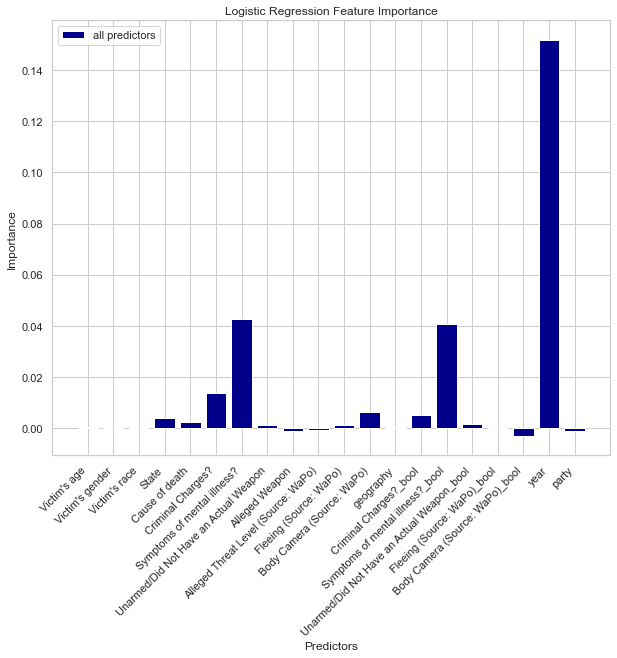

In [86]:
# find predictors
importance = permutation_importance(logreg,
                                    X_train,
                                    y_train,
                                    n_repeats=5
                                   )

# take top 10
#importance = np.sort(importance)[:10]
cols = X.columns

# summarize feature importance
#for i,v in enumerate(importance.importances_mean):
#    print(f'Feature {i}: {cols[i]}   Score: {v:.4f}')

# plot feature importance
fig = plt.figure(figsize=(10,8))
plt.bar([x for x in range(len(importance.importances_mean))], importance.importances_mean, color='darkblue', label='all predictors')
plt.title('Logistic Regression Feature Importance')
plt.xticks(np.arange(len(cols)), cols, rotation=45, horizontalalignment='right')
plt.ylabel('Importance')
plt.xlabel('Predictors')
plt.legend()
plt.show()

In [87]:
# predict using test set
y_pred_test = logreg.predict(X_test)


# get performance by class
print('\nOverall Test Set Performance')
cm1 = pd.crosstab(y_test, 
                  y_pred_test, 
                  margins=True, 
                  rownames=['Actual'], 
                  colnames=['Predicted'])
display(cm1)


Overall Test Set Performance


Predicted,2,3,4,8,9,13,All
Actual,,,,,,,
0,2,1,0,0,0,0,3
1,0,1,0,0,0,0,1
2,4,2,0,0,1,0,7
3,3,14,2,0,8,2,29
4,0,0,23,0,157,118,298
6,0,0,0,0,3,0,3
8,0,0,2,1,77,4,84
9,0,0,19,3,912,37,971
10,0,0,0,0,1,0,1


In [88]:
# Try polynomial features up to 3rd order polynomials
degree = 3

# define data
X_train_poly = PolynomialFeatures(degree=degree,
                                  include_bias=False).fit_transform(X_train)
X_test_poly = PolynomialFeatures(degree=degree,
                                 include_bias=False).fit_transform(X_test)
# fit model
polyreg3 = LogisticRegression(penalty='none', 
                              max_iter = 5000).fit(X_train_poly, y_train)

# Check accuracy score
polyreg3_train_accuracy = polyreg3.score(X_train_poly, y_train)*100
polyreg3_test_accuracy = polyreg3.score(X_test_poly, y_test)*100

# Print results
print("Polynomial Features Logistic Regression Model Accuracy Results:")
print(f'  Logisitic Train Accuracy with 3rd Order Polynomial Features: {polyreg3_train_accuracy:.2f}%')
print(f'  Logisitic Test Accuracy with 3rd Order Polynomial Features: {polyreg3_test_accuracy:.2f}%')

Polynomial Features Logistic Regression Model Accuracy Results:
  Logisitic Train Accuracy with 3rd Order Polynomial Features: 67.83%
  Logisitic Test Accuracy with 3rd Order Polynomial Features: 65.63%


In [89]:
# Try Regularized Model
c = 1

# generate model
logit_lasso = LogisticRegression(C=c, 
                                 penalty='l1', 
                                 solver='saga', 
                                 max_iter = 5000).fit(X_train, y_train)

#Perfromance Evaluation
logit_lasso_train_accuracy = logit_lasso.score(X_train, y_train)*100
logit_lasso_test_accuracy = logit_lasso.score(X_test, y_test)*100

# Beta Values
intercept = logit_lasso.intercept_[0]
betas = logit_lasso.coef_[0]

# Print results
print("Best (C=100) Lasso Model Estimated Coefficients:")
print(f'Intercept: {intercept:.4f}')
#for idx, val in enumerate(betas):
    #print(f'Beta {idx+1} value: {val:.4f}')
print(f'Best Lasso Train Accuracy: {logit_lasso_train_accuracy:.2f}%')
print(f'Best Lasso Test Accuracy: {logit_lasso_test_accuracy:.2f}%')

Best (C=100) Lasso Model Estimated Coefficients:
Intercept: -0.0716
Best Lasso Train Accuracy: 65.20%
Best Lasso Test Accuracy: 64.22%


In [90]:
# initialize
tree_depth = 10
seed = 0
n_estimators = 55

random_forest = RandomForestClassifier(max_depth=tree_depth, 
                                       #random_state=seed,
                                       max_features='sqrt',
                                       n_estimators=n_estimators)

# Fit the model on the training set
random_forest.fit(X_train, y_train)

# scores
random_forest_train_accuracy = random_forest.score(X_train, y_train)*100
random_forest_test_accuracy = random_forest.score(X_test, y_test)*100

# print results
print(f'Random Forest Train Accuracy: {random_forest_train_accuracy:.2f}%')
print(f'Random Forest Test Accuracy: {random_forest_test_accuracy:.2f}%')

Random Forest Train Accuracy: 74.55%
Random Forest Test Accuracy: 68.39%


In [91]:
# try neural net

# couple extra imports
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# initialize
# The number of nodes in a hidden layer
n_hidden = 15
# The number of nodes in the input layer (features)
n_input = len(X_train.columns)
# The number of nodes in the output layer
n_output = 1

# First we instantiate a Keras model
NN_model = models.Sequential(name='ANN')

# Adding Layers
NN_model.add(layers.Dense(n_hidden, 
                          activation='relu', 
                          input_shape=[n_input,], 
                          name='hidden1'))
NN_model.add(layers.Dense(n_hidden, 
                          activation='relu',  
                          name='hidden2'))

# Now add the output layer
NN_model.add(layers.Dense(n_output, 
                          activation='sigmoid',  
                          name='output'))

# initialize
epochs = 200

# Compilation
NN_model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

#View model summary
display(NN_model.summary())

#Fit the model on the training data
NN_model.fit(X_train, 
             y_train, 
             epochs=epochs,
             verbose=0,
             validation_split=0.2)

# evaluate
NN_train_accuracy = NN_model.evaluate(X_train,y_train)[1]*100
NN_test_accuracy = NN_model.evaluate(X_test,y_test)[1]*100

# print results
print(f'\nThe training set accuracy for the model is: {NN_train_accuracy:.2f}%')
print(f'The test set accuracy for the model is: {NN_test_accuracy:.2f}%')

Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 15)                315       
_________________________________________________________________
hidden2 (Dense)              (None, 15)                240       
_________________________________________________________________
output (Dense)               (None, 1)                 16        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


None

1702/1702 [==============================] - 0s 36us/sample - loss: -4784699340.8602 - acc: 5.8754e-04

The training set accuracy for the model is: 0.00%
The test set accuracy for the model is: 0.06%


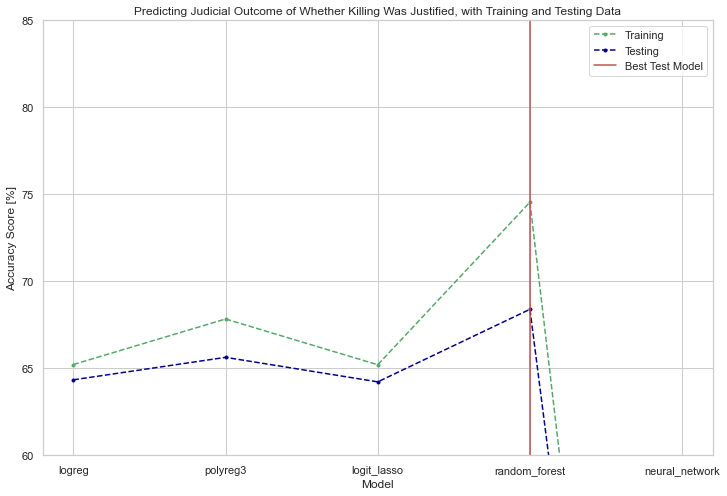

In [92]:
# compare various models
acc_dict_train = {'logreg': logreg_train_accuracy,
                  'polyreg3': polyreg3_train_accuracy,
                  'logit_lasso': logit_lasso_train_accuracy,
                  'random_forest': random_forest_train_accuracy, 
                  'neural_network': NN_train_accuracy
                 }
acc_dict_test = {'logreg': logreg_test_accuracy,
                 'polyreg3': polyreg3_test_accuracy,
                 'logit_lasso': logit_lasso_test_accuracy,
                 'random_forest': random_forest_test_accuracy,
                 'neural_network': NN_test_accuracy
                 }


# Look at our projections so far
X = np.arange(len(acc_dict_train))

fig = plt.figure(figsize=(12,8))
plt.plot(X, acc_dict_train.values(), '--.', color='g', label="Training")
plt.plot(X, acc_dict_test.values(), '--.', color='darkblue', label='Testing')
plt.title('Predicting Judicial Outcome of Whether Killing Was Justified, with Training and Testing Data')
plt.axvline(3, 0, 100, color = 'r', label = f'Best Test Model')
plt.xlabel('Model')
plt.ylabel('Accuracy Score [%]')
plt.xticks(X, acc_dict_train.keys())
plt.ylim(60,85)
plt.legend()
plt.show()

### End of Notebook